# **Rossmann Store Sales Analysis**

## **Overview**
This notebook explores the **Rossmann Store Sales** dataset from Kaggle. The goal is to analyze sales data from over 1,000 Rossmann stores to predict future sales accurately.

**Competition Link**: [Rossmann Store Sales on Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales?authuser=1)

## Dataset Description
Rossmann operates over 3,000 drug stores in 7 European countries. This dataset contains historical sales data for 1,115 stores, including promotional, seasonal, and store-specific information.



### Data Files
1. **`train.csv`** - Historical sales data (2013-01-01 to 2015-07-31)
   - `Store` - Unique store ID
   - `DayOfWeek` - Day of the week (1-7)
   - `Date` - Sales date
   - `Sales` - Turnover (target variable)
   - `Customers` - Number of customers
   - `Open` - Store opening status (0/1)
   - `Promo` - Promotion active (0/1)
   - `StateHoliday` - Public holiday status
   - `SchoolHoliday` - School holiday status

2. **`store.csv`** - Supplemental store information
   - `StoreType` - Store category (a-d)
   - `Assortment` - Product variety level
   - `CompetitionDistance` - Distance to nearest competitor
   - `CompetitionOpenSince[Month/Year]`
   - `Promo2` - Ongoing promotion (0/1)
   - `Promo2Since[Year/Week]`
   - `PromoInterval` - Promotion intervals

3. **`test.csv`** - Test set for prediction (2015-08-01 to 2015-09-17)

## Objectives
- Perform exploratory data analysis (EDA)
- Identify key sales drivers
- Handle missing values and outliers
-  Build time-series forecasting models
- Evaluate model performance (RMSE)

## Key Questions
1. How do promotions affect sales?
2. What's the impact of holidays?
3. How does competition distance influence performance?
4. Are there seasonal patterns in sales?


# `01` **Analysis of the data**

# `A` **import libraries**

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# `B` **load data**

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
store = pd.read_csv('data/store.csv')

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\2710493378.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


In [ ]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

In [6]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [19]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
test.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

### Merge store data with train and test

In [ ]:
train = pd.merge(train,store,on='Store',how='left')
test = pd.merge(test,store on='Store',how='left')

In [9]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

# `C` **Analysis and EDA**

### check for nulls

In [10]:
train.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

In [11]:
test.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

### check for duplicates

In [13]:
train.duplicated().sum()

0

In [14]:
test.duplicated().sum()

0

### distrubition of sales

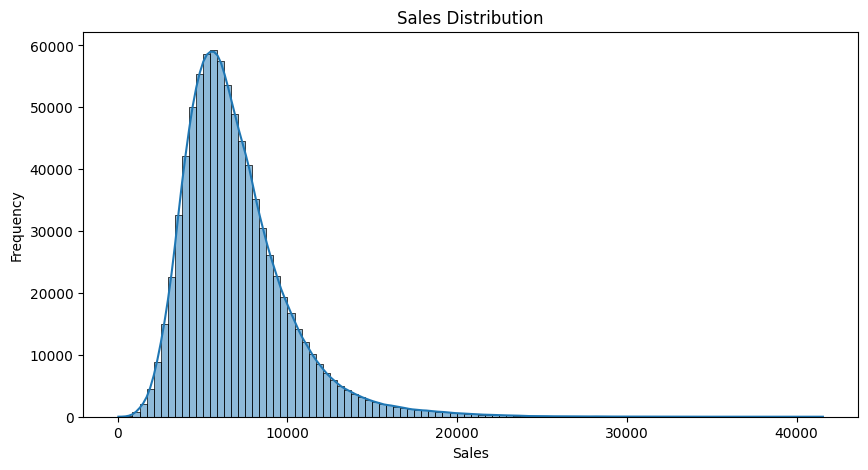

In [70]:
plt.figure(figsize=(10,5))
sns.histplot(train[train['Sales'] > 0]['Sales'], bins=100, kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

### sales over years

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['DayOfWeek'] = train['Date'].dt.dayofweek

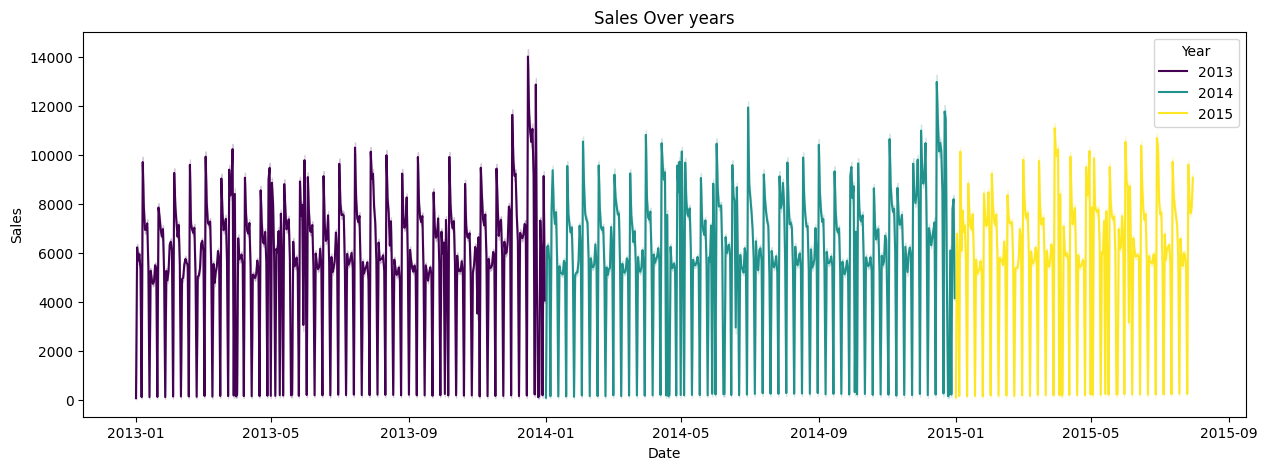

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=train, x='Date', y='Sales', hue='Year',palette='viridis')
plt.title('Sales Over years')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

### Sales for each store

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\2630543718.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='StoreType', y='Sales', palette='Set2', order=['a', 'b', 'c', 'd'])


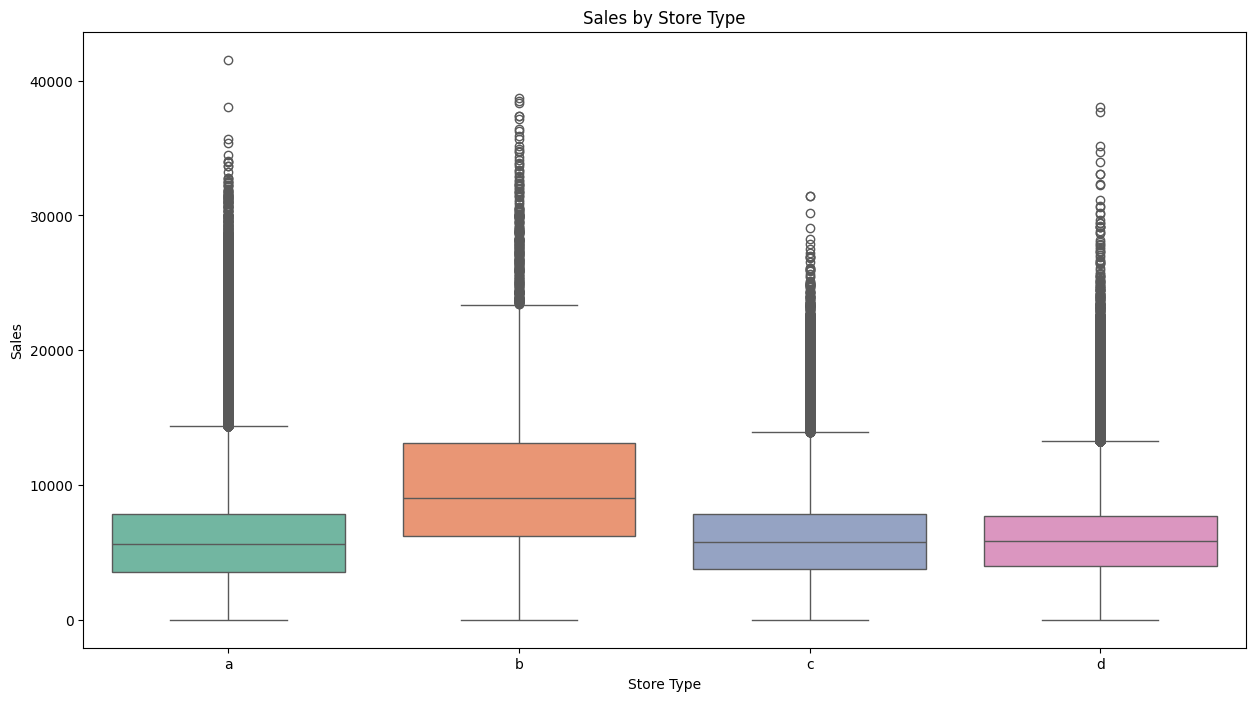

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=train, x='StoreType', y='Sales', palette='Set2', order=['a', 'b', 'c', 'd'])
plt.title('Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

- store b has the most sales

### sales over days

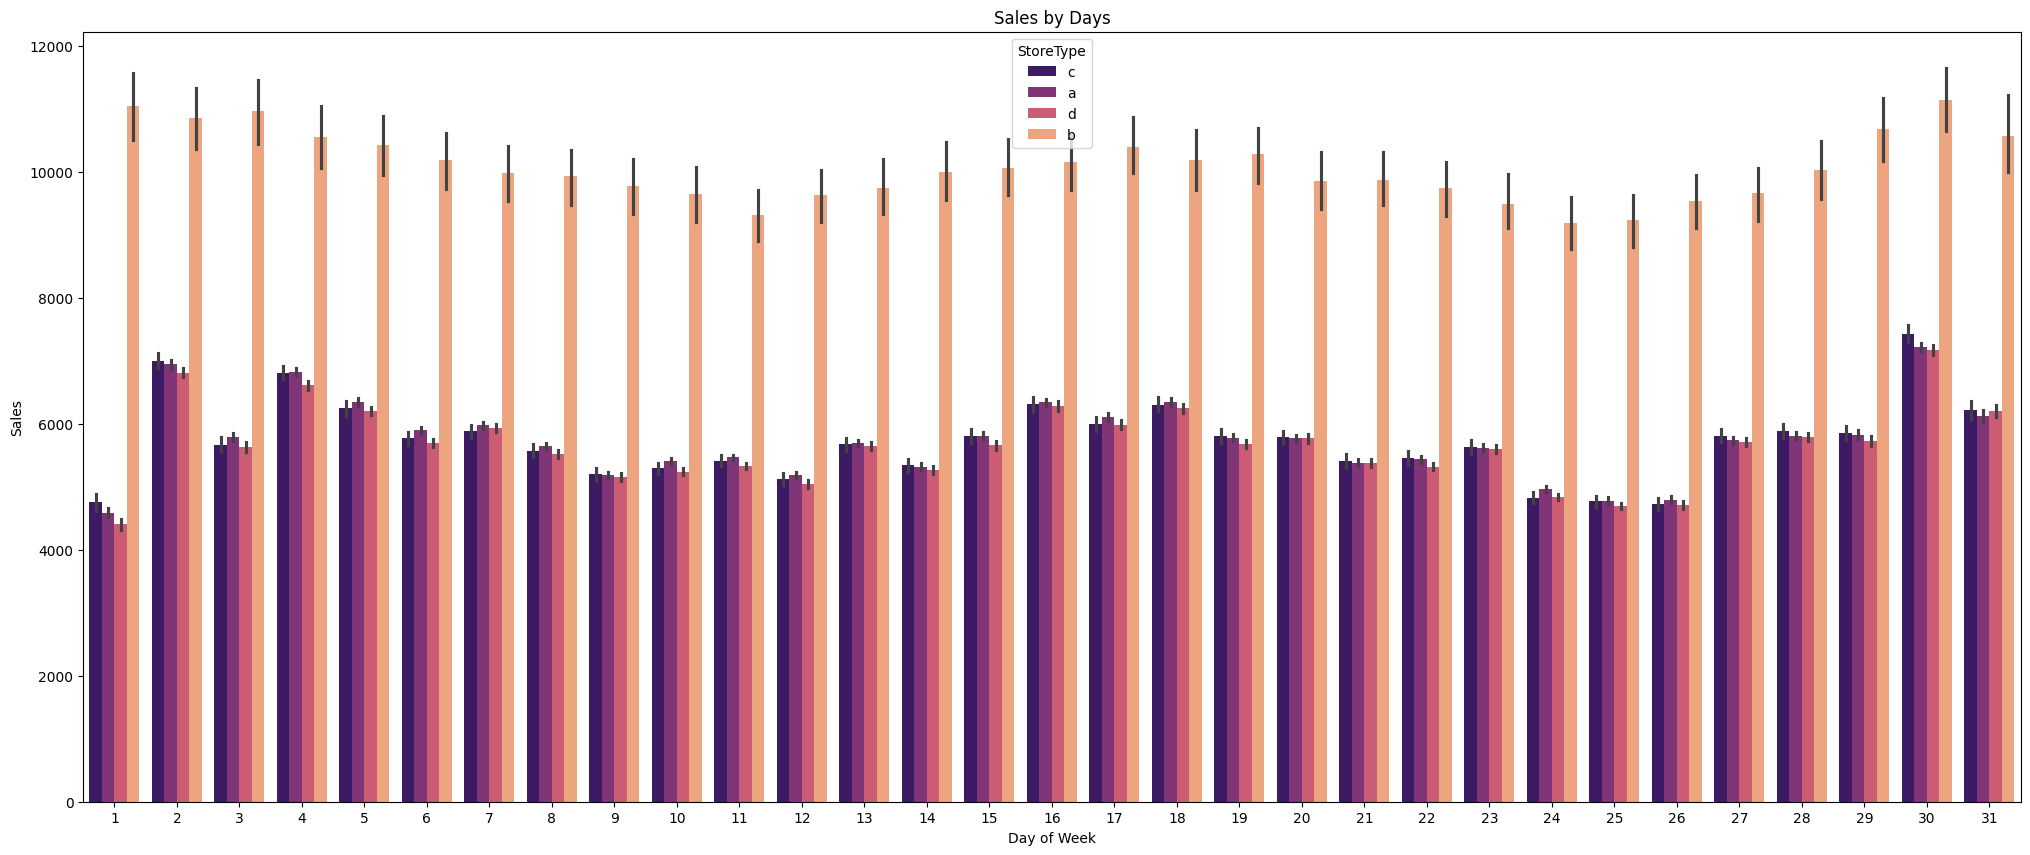

In [39]:
plt.figure(figsize=(25,10))
sns.barplot(data=train, x='Day', y='Sales', hue='StoreType', palette='magma')
plt.title('Sales by Days')
plt.xlabel('Day of Month')
plt.ylabel('Sales')
plt.show()

### sales over month

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\394251028.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='Month', y='Sales',palette='magma')


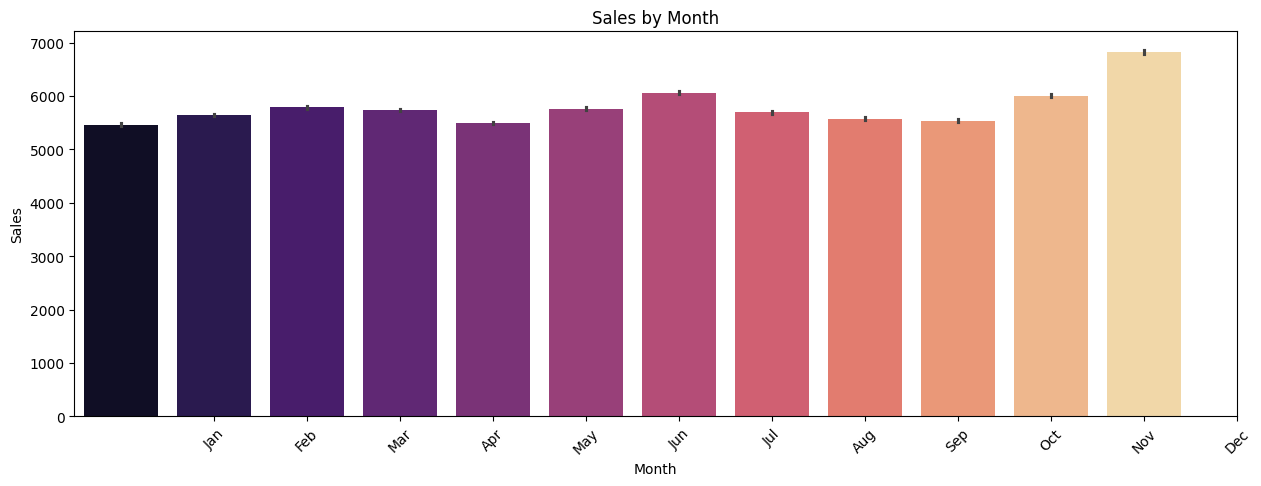

In [52]:
plt.figure(figsize=(15,5))
sns.barplot(data=train, x='Month', y='Sales',palette='magma')
plt.title('Sales by Month')
plt.xticks(np.arange(1, 13), 
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

### sales over days in week

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\1802128087.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='DayOfWeek', y='Sales',palette='magma')


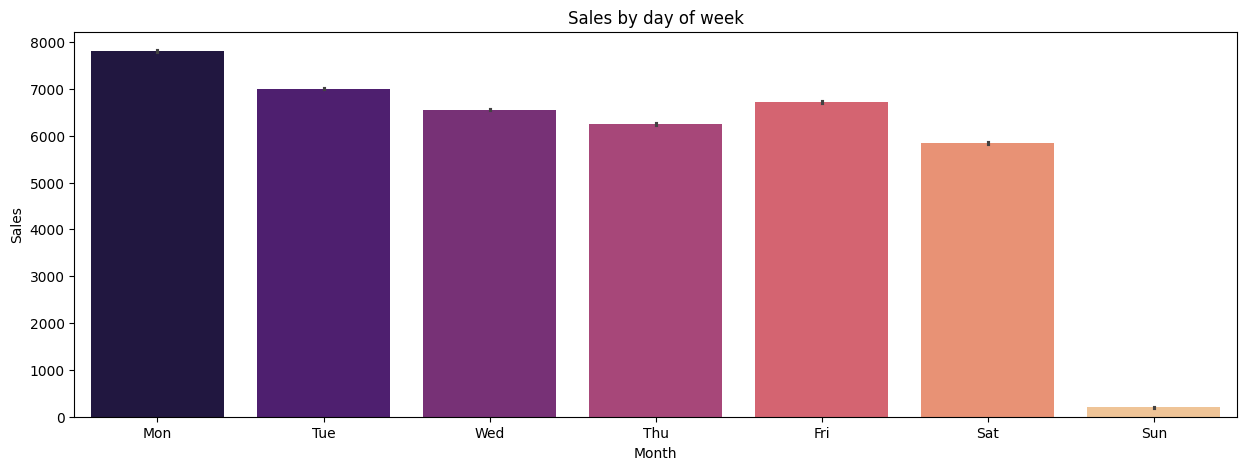

In [55]:
plt.figure(figsize=(15,5))
sns.barplot(data=train, x='DayOfWeek', y='Sales',palette='magma')
plt.title('Sales by day of week')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

### sales over stateholidays

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\4073579007.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='StateHoliday', y='Sales',palette='Set2')


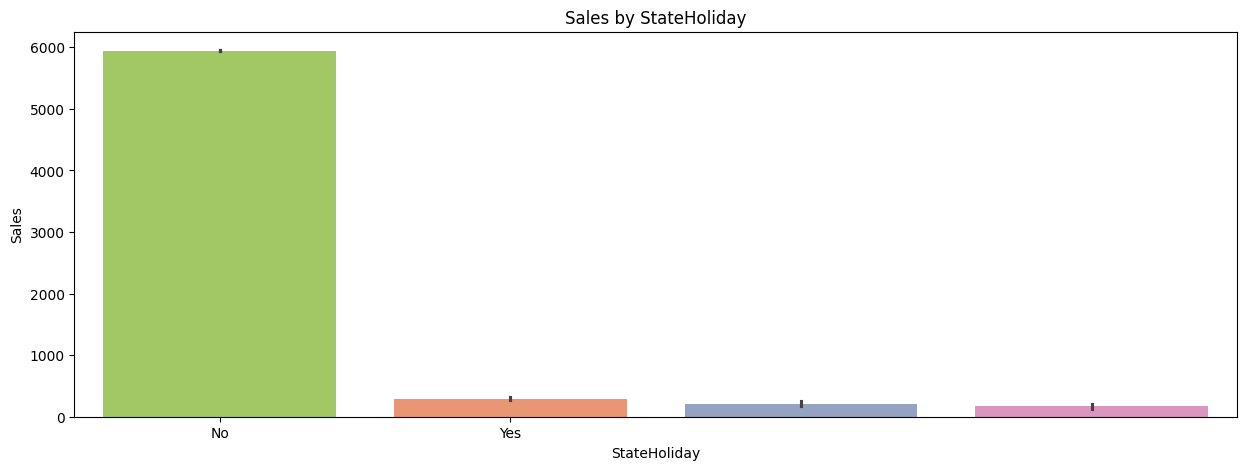

In [56]:
plt.figure(figsize=(15,5))
sns.barplot(data=train, x='StateHoliday', y='Sales',palette='Set2')
plt.title('Sales by StateHoliday')
plt.xlabel('StateHoliday')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Sales')
plt.show()

### sales over schoolholidays

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\238067602.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='SchoolHoliday', y='Sales', palette='Set2')


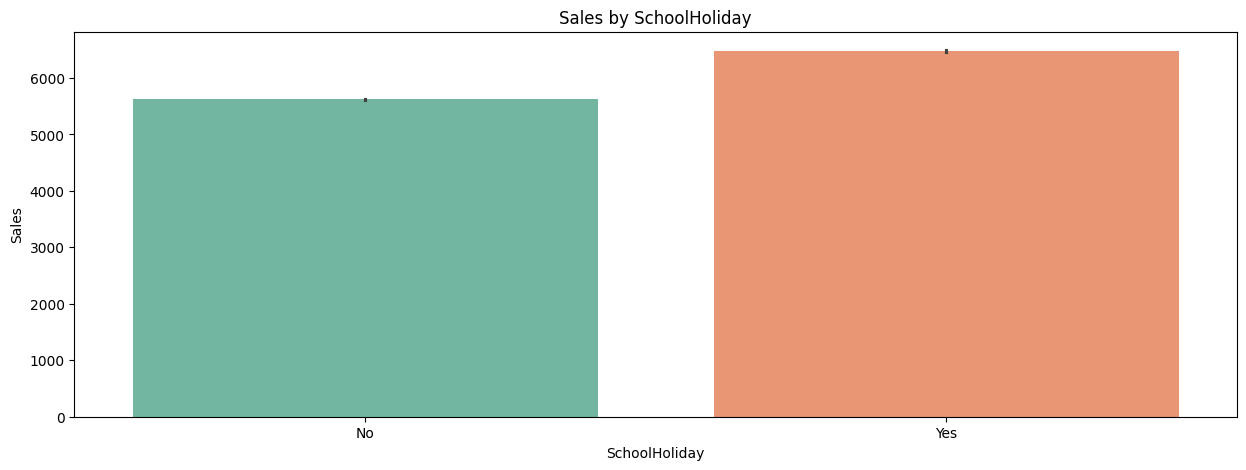

In [46]:
plt.figure(figsize=(15,5))
sns.barplot(data=train, x='SchoolHoliday', y='Sales', palette='Set2')
plt.title('Sales by SchoolHoliday')
plt.xlabel('SchoolHoliday')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Sales')
plt.show()

### Sales with promocodes

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\4154349092.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train, x='Promo', y='Sales', palette='Set1')


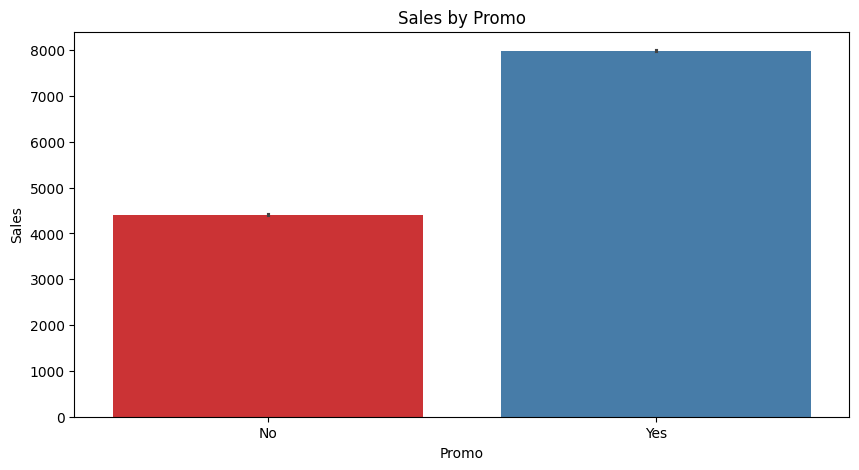

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(data=train, x='Promo', y='Sales', palette='Set1')
plt.title('Sales by Promo')
plt.xlabel('Promo')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Sales')
plt.show()

### sales by Assortment

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\1473279233.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train, x='Assortment', y='Sales', palette='Set2', order=['a', 'b', 'c'])


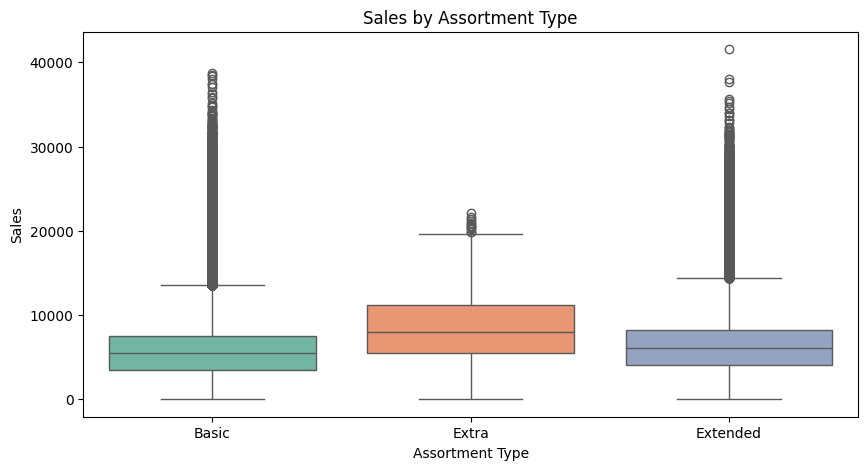

In [57]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train, x='Assortment', y='Sales', palette='Set2', order=['a', 'b', 'c'])
plt.title('Sales by Assortment Type')
plt.xlabel('Assortment Type')
plt.xticks(ticks=[0, 1, 2], labels=['Basic', 'Extra', 'Extended'])  
plt.ylabel('Sales')
plt.show()

### Open stores 

C:\Users\Omar Elgema3y\AppData\Local\Temp\ipykernel_12408\42093480.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='Open', palette='Set2')


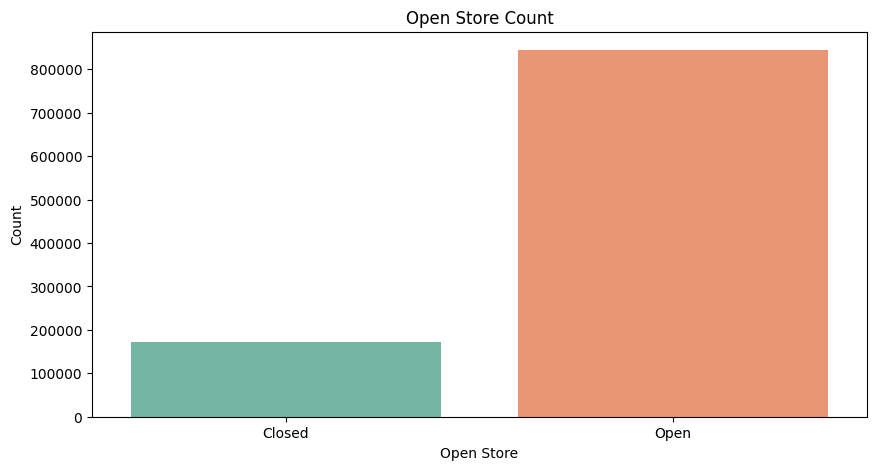

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='Open', palette='Set2')
plt.title('Open Store Count')
plt.xlabel('Open Store')
plt.xticks([0, 1], ['Closed', 'Open'])
plt.ylabel('Count')
plt.show()

### Correlation Matrix

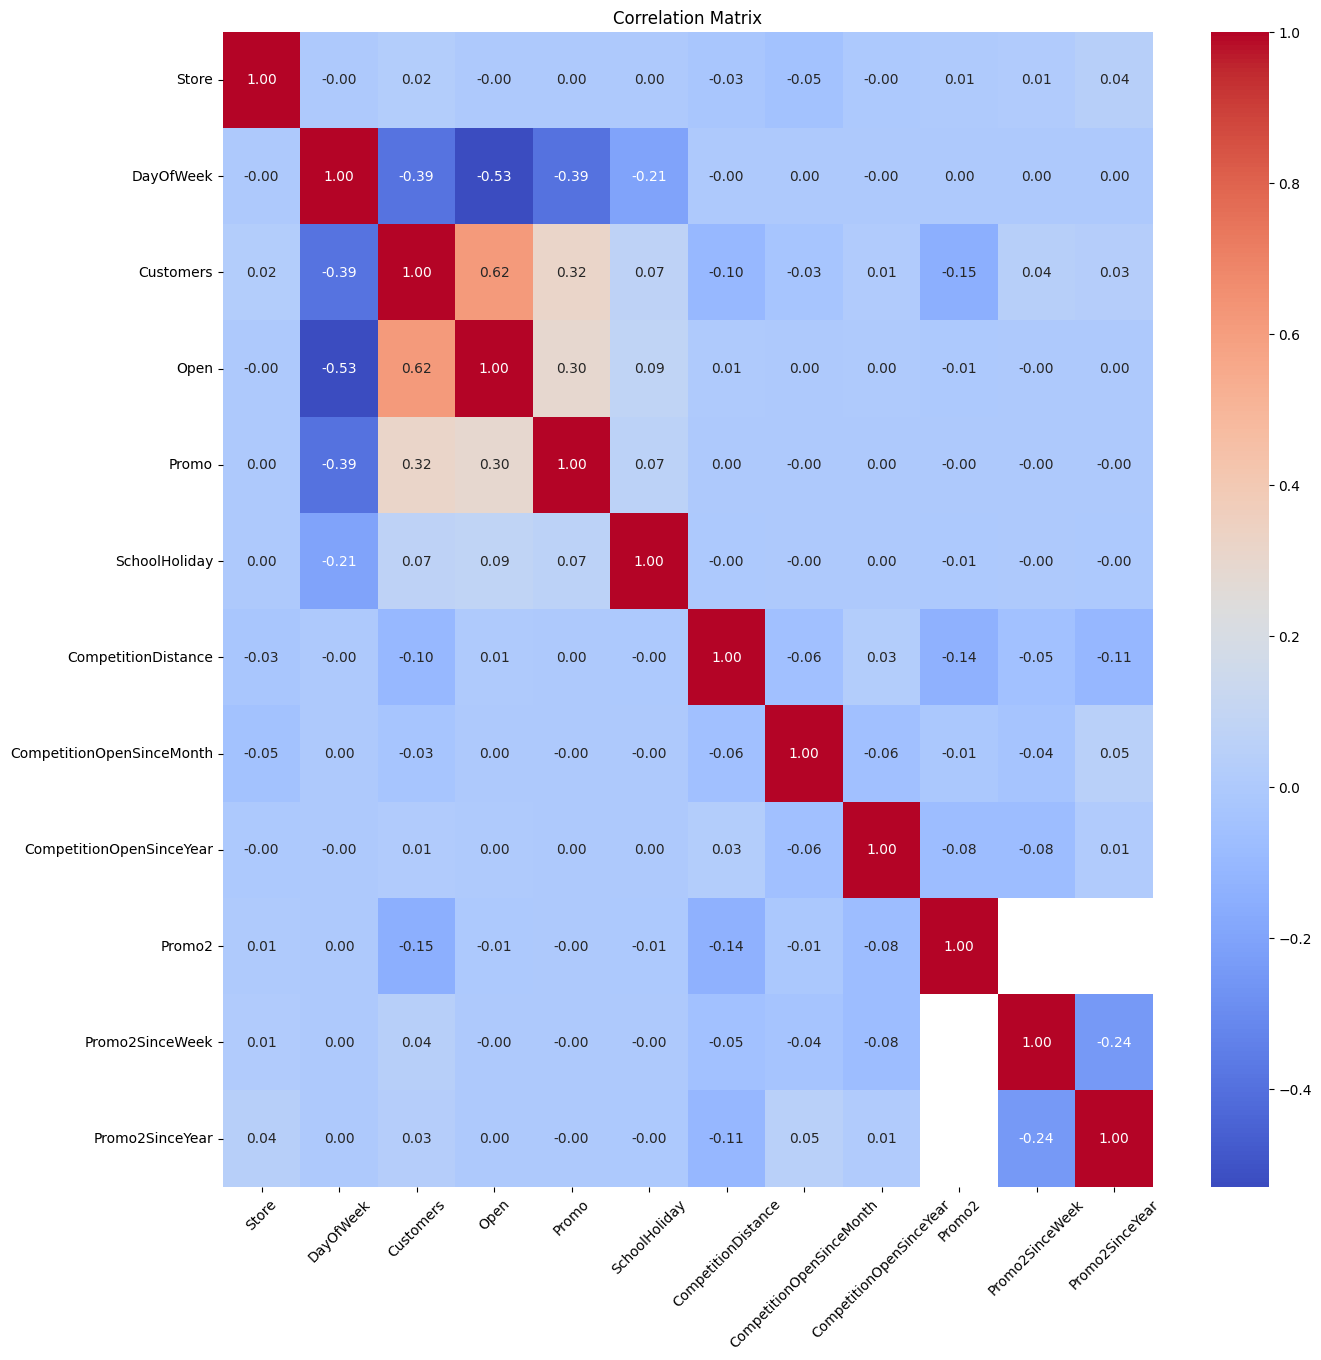

In [68]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Sales', 'Year', 'Month', 'Day']]
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(rotation=45)
plt.title('Correlation Matrix')
plt.show()

# `D` **Decomposition**

### decomposition of some stores with different seasonality

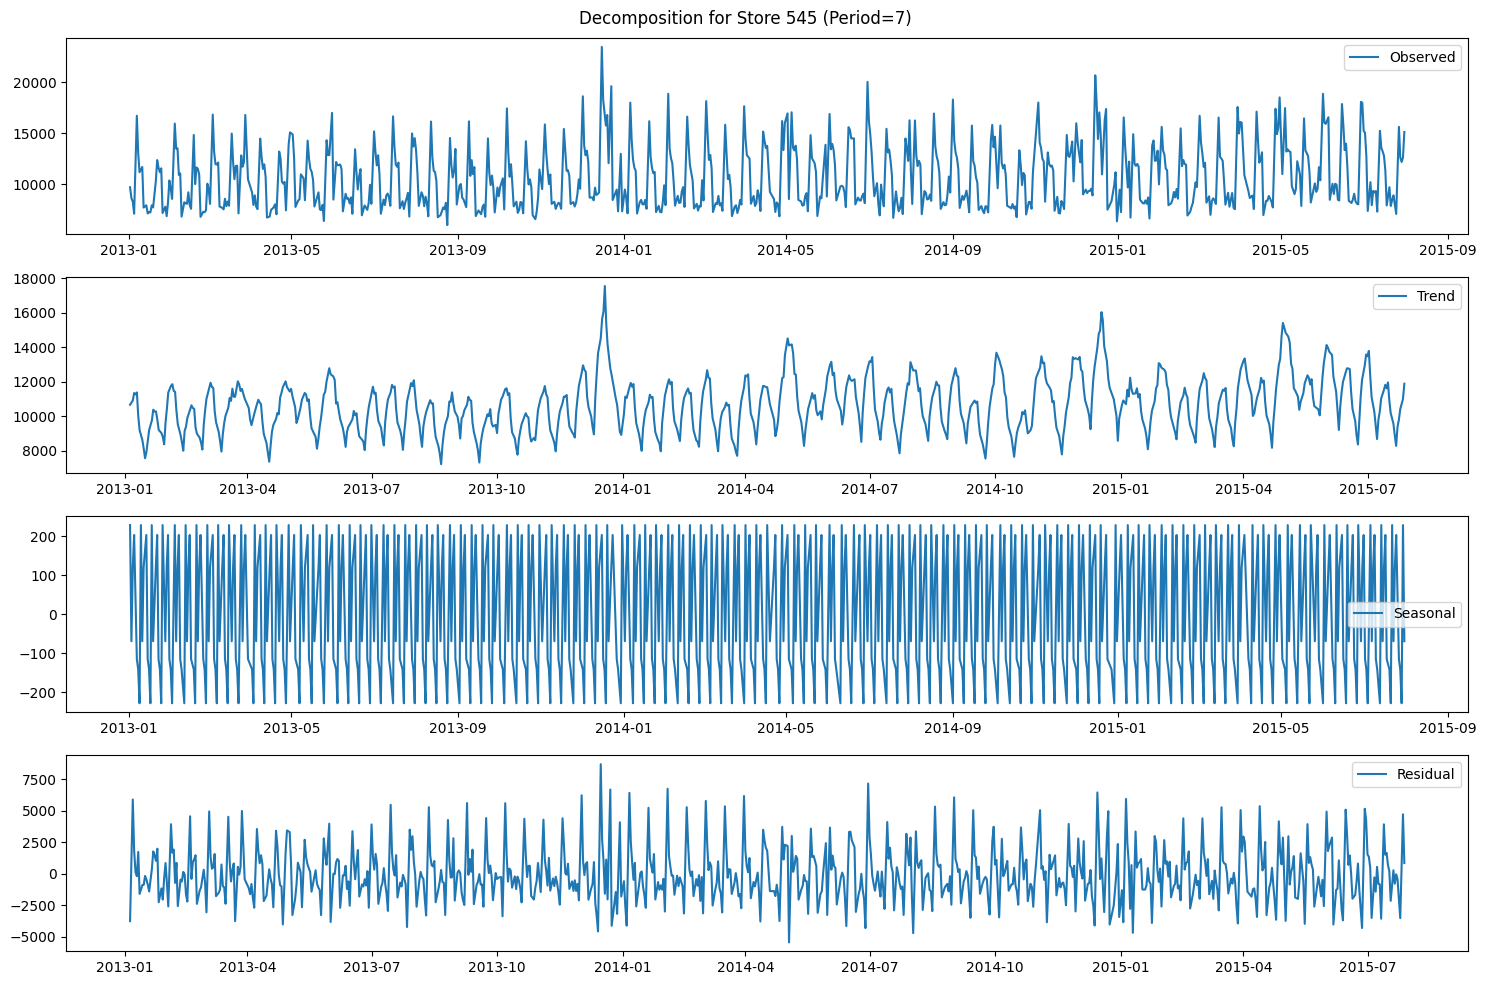

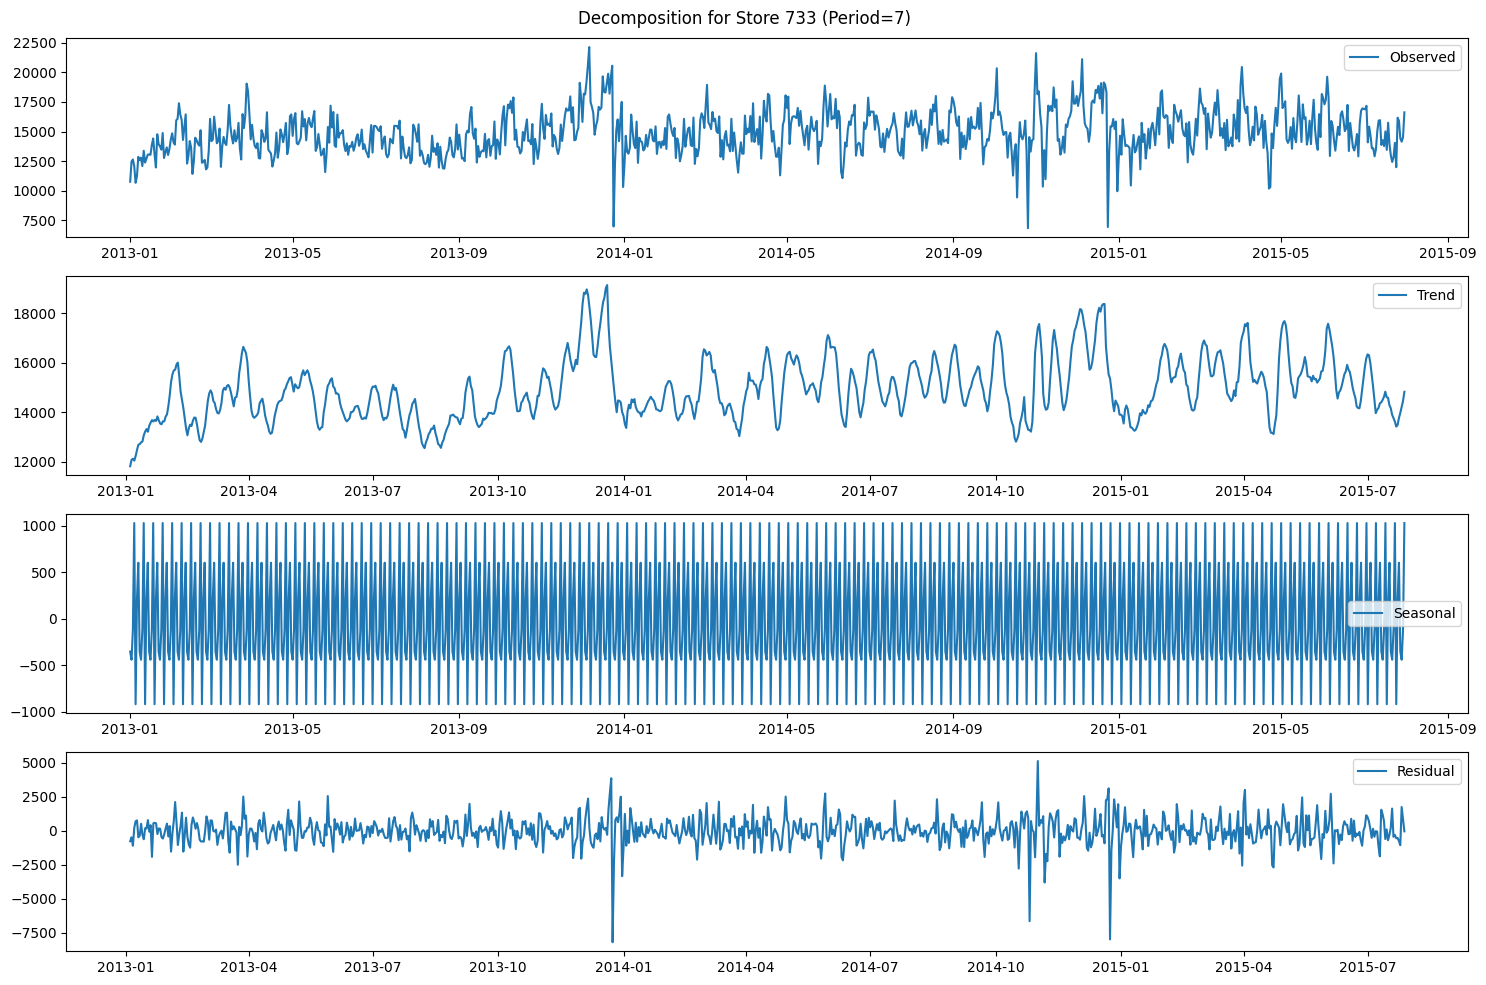

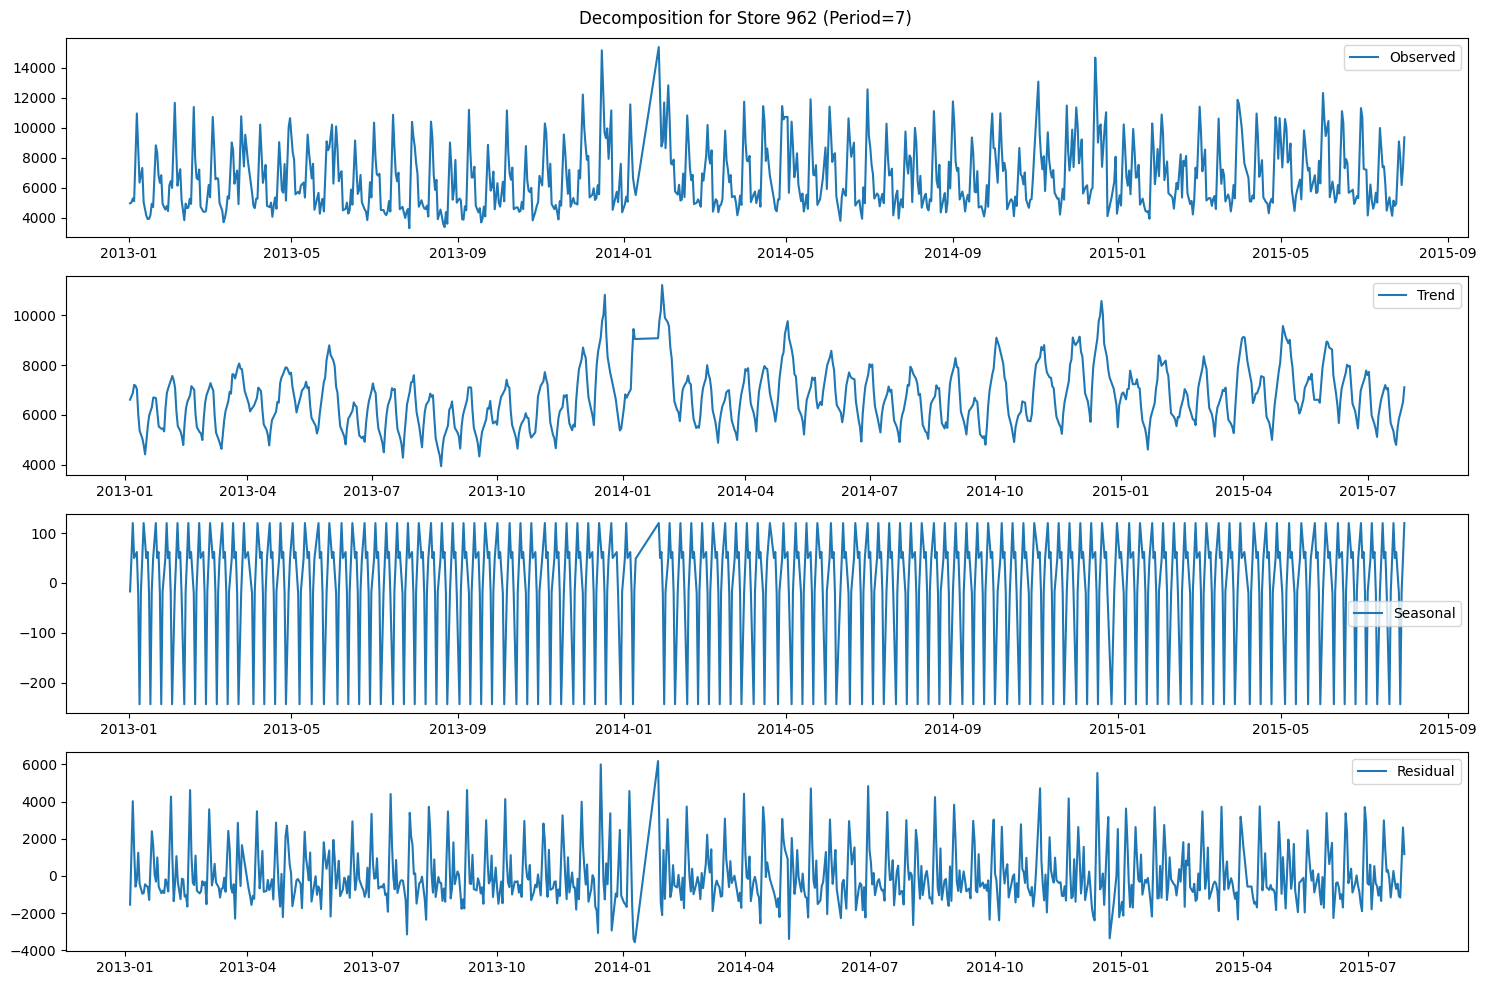

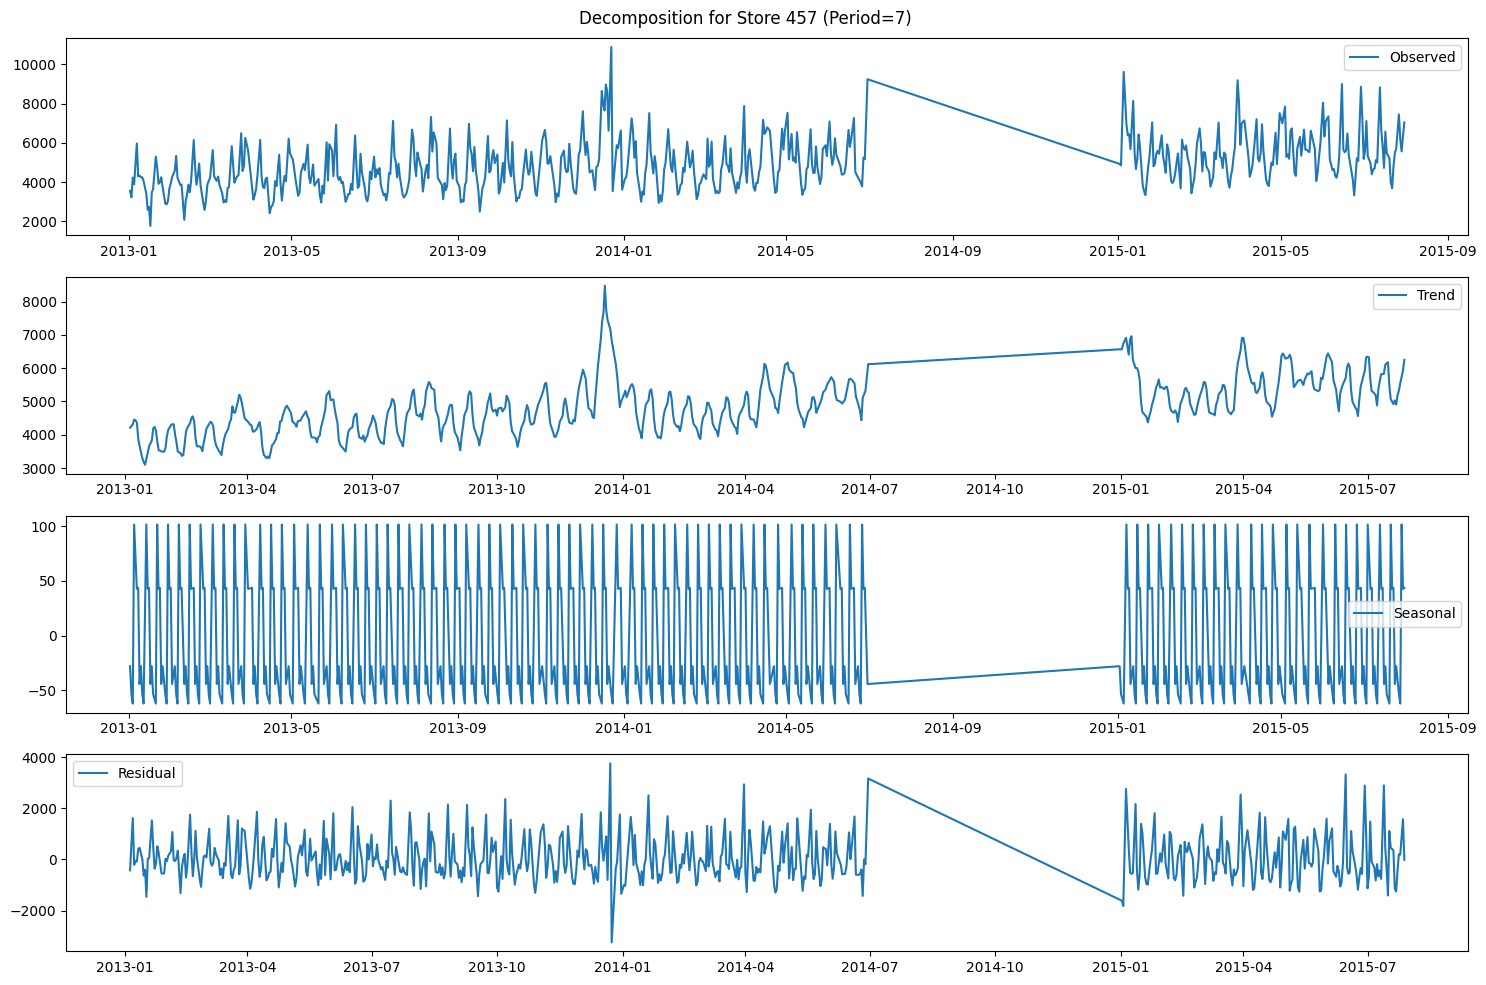

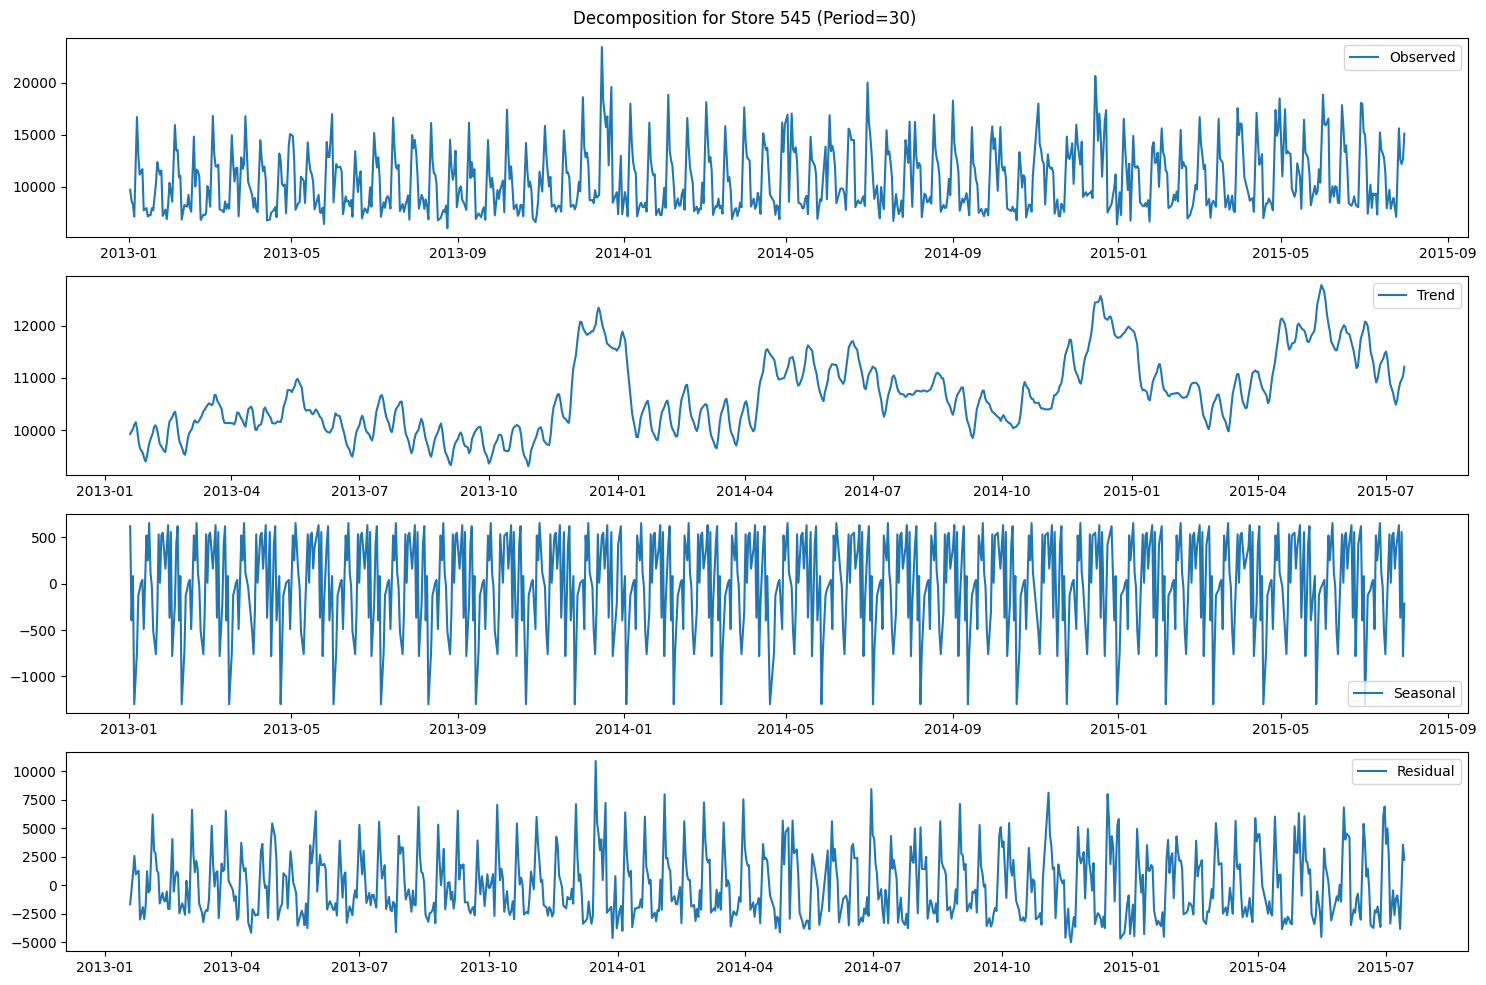

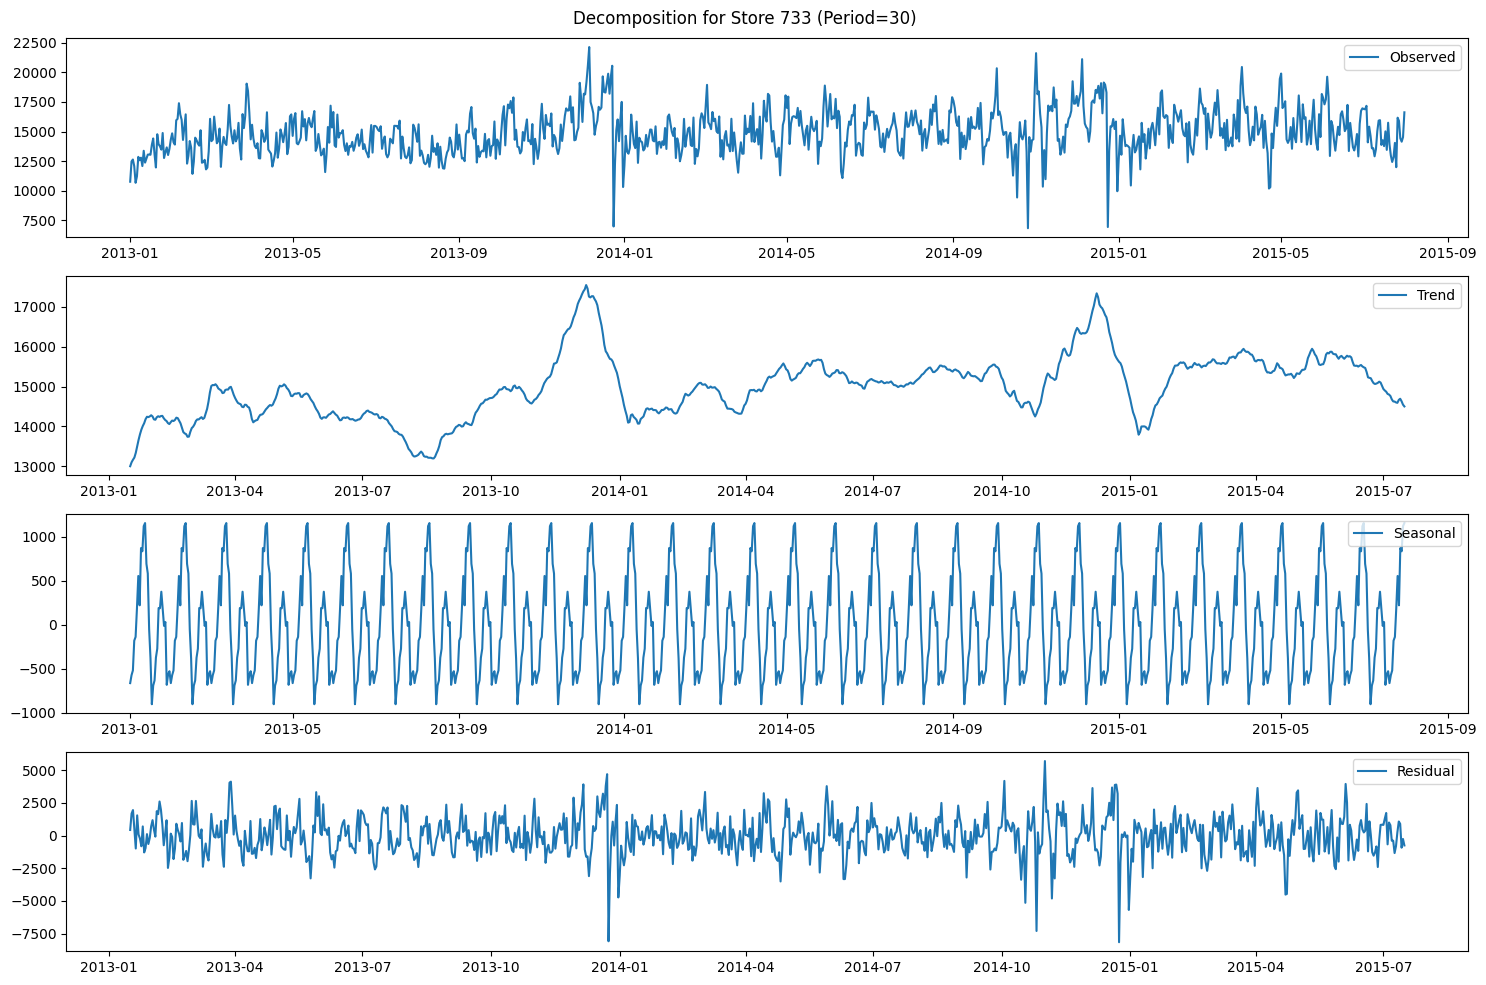

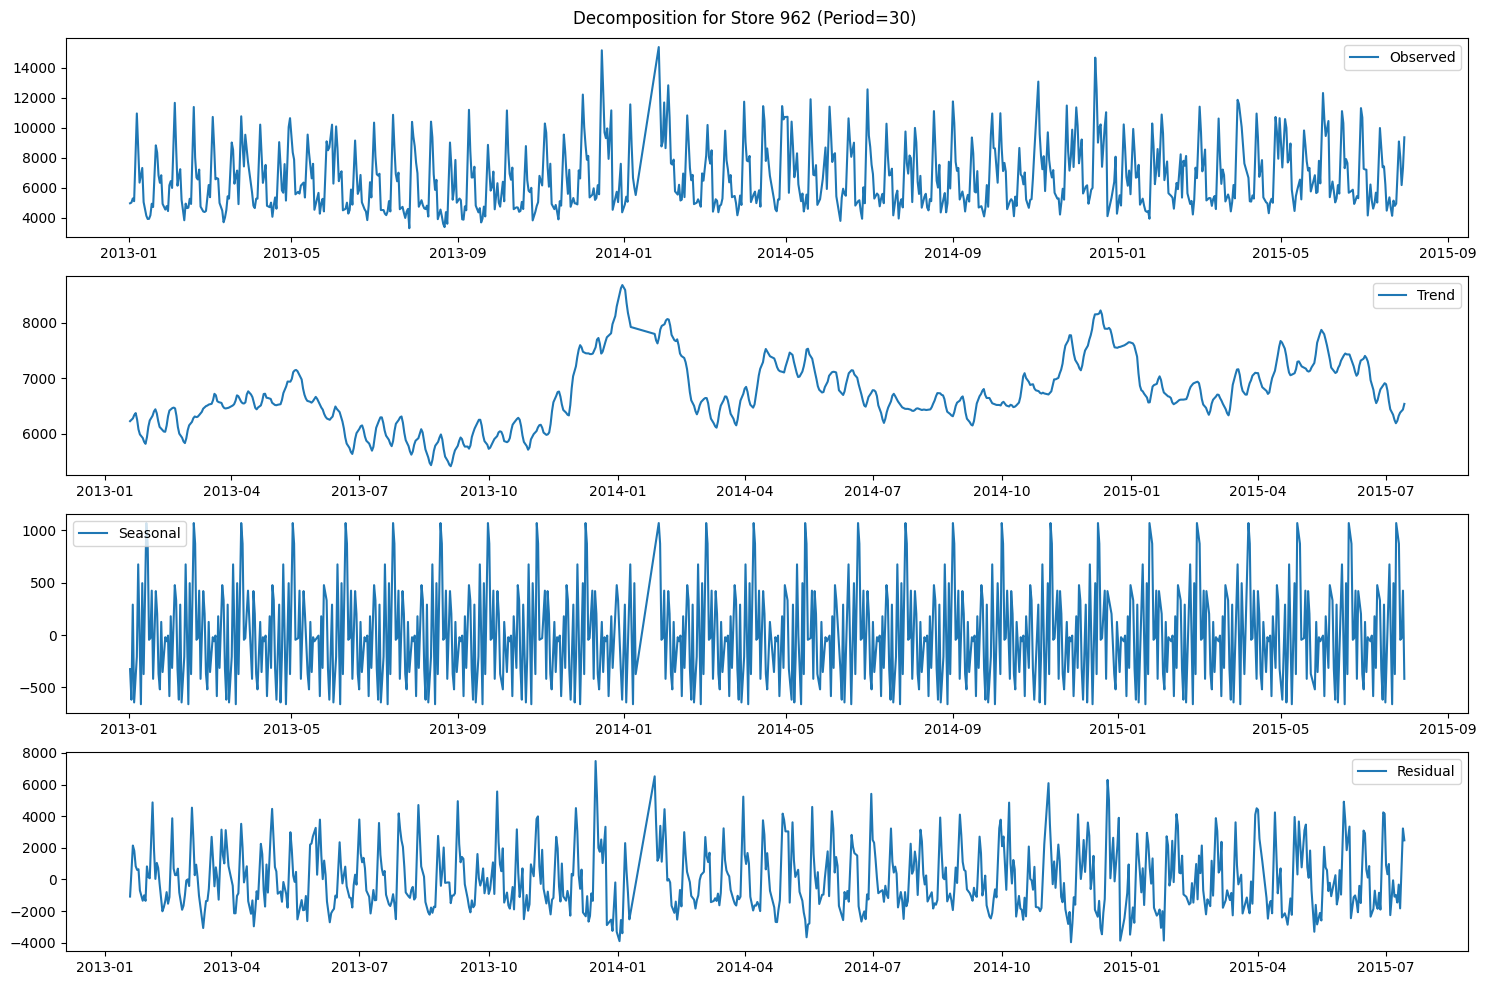

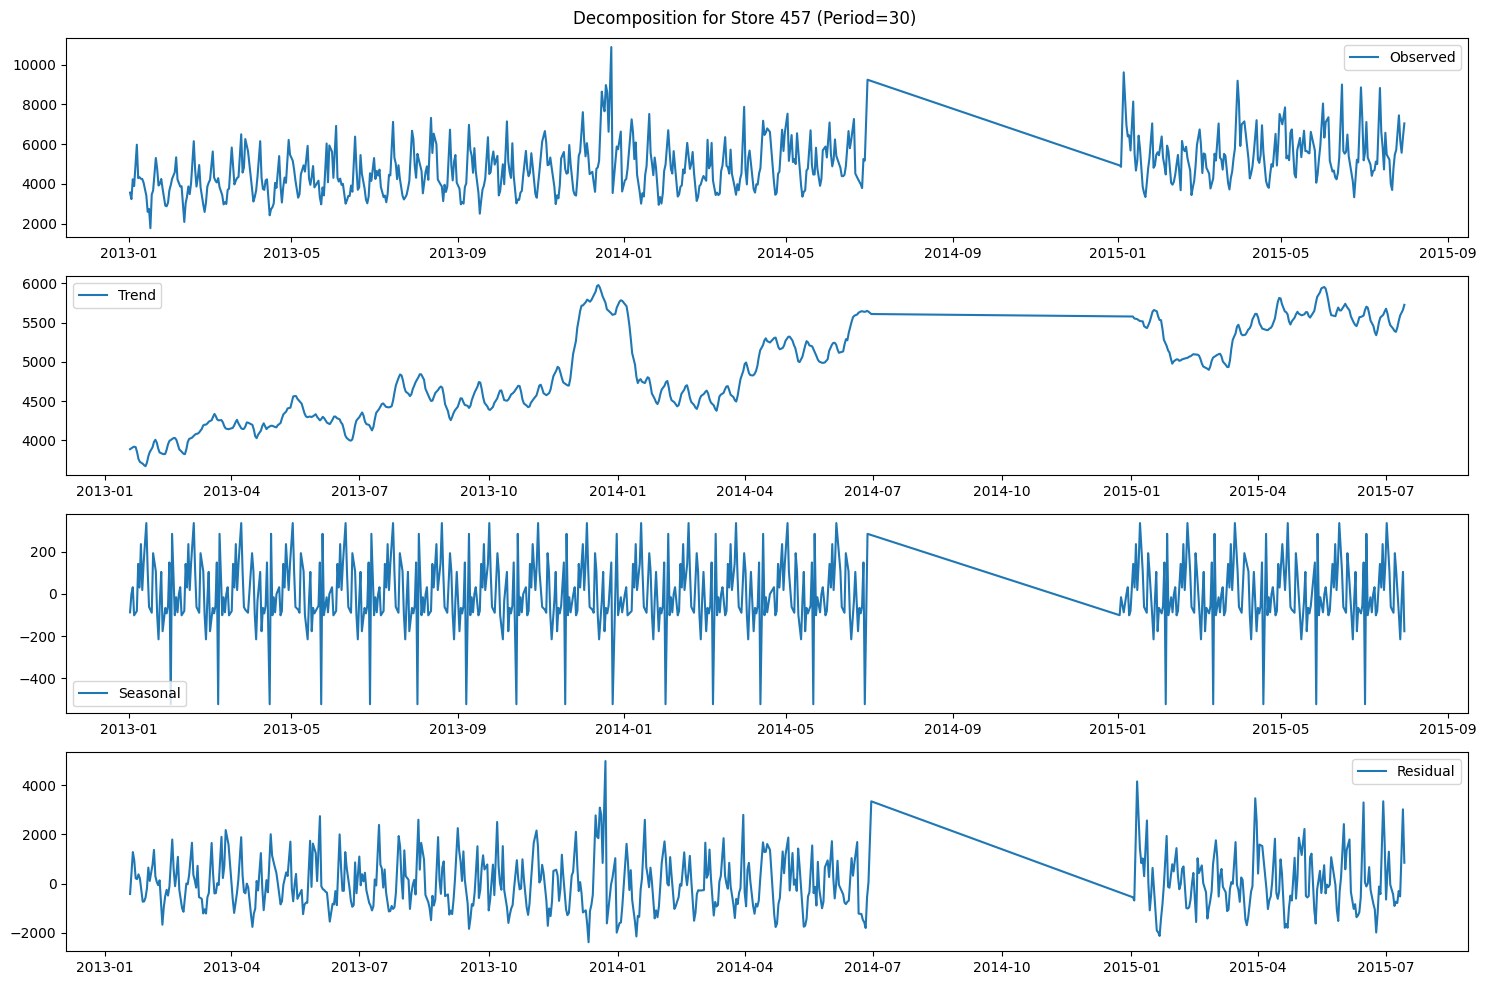

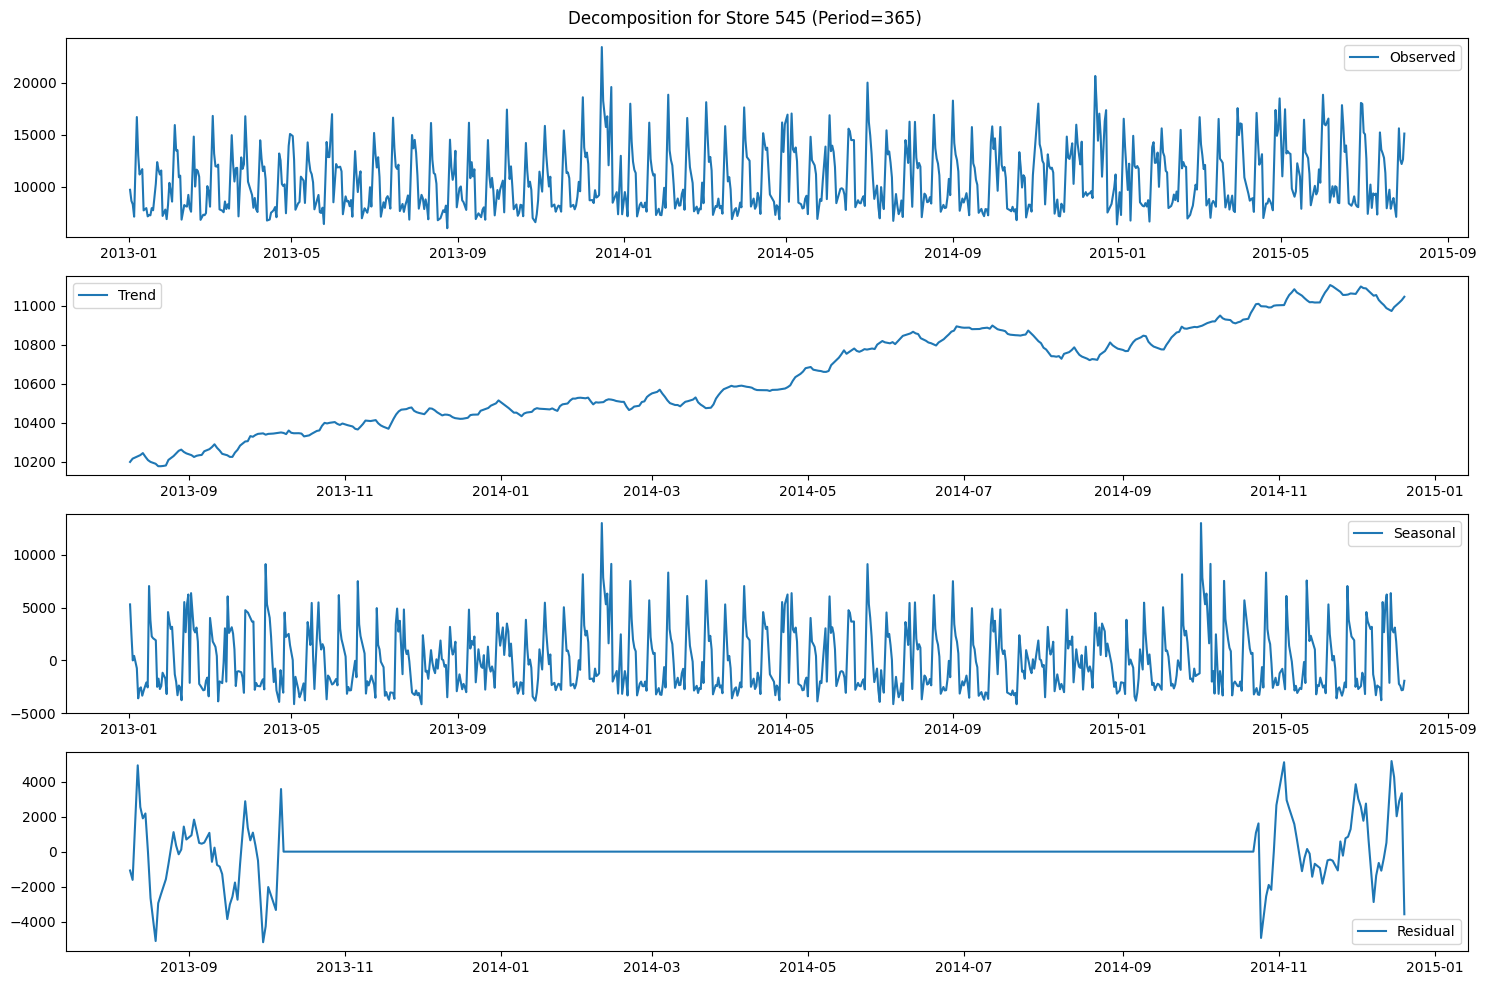

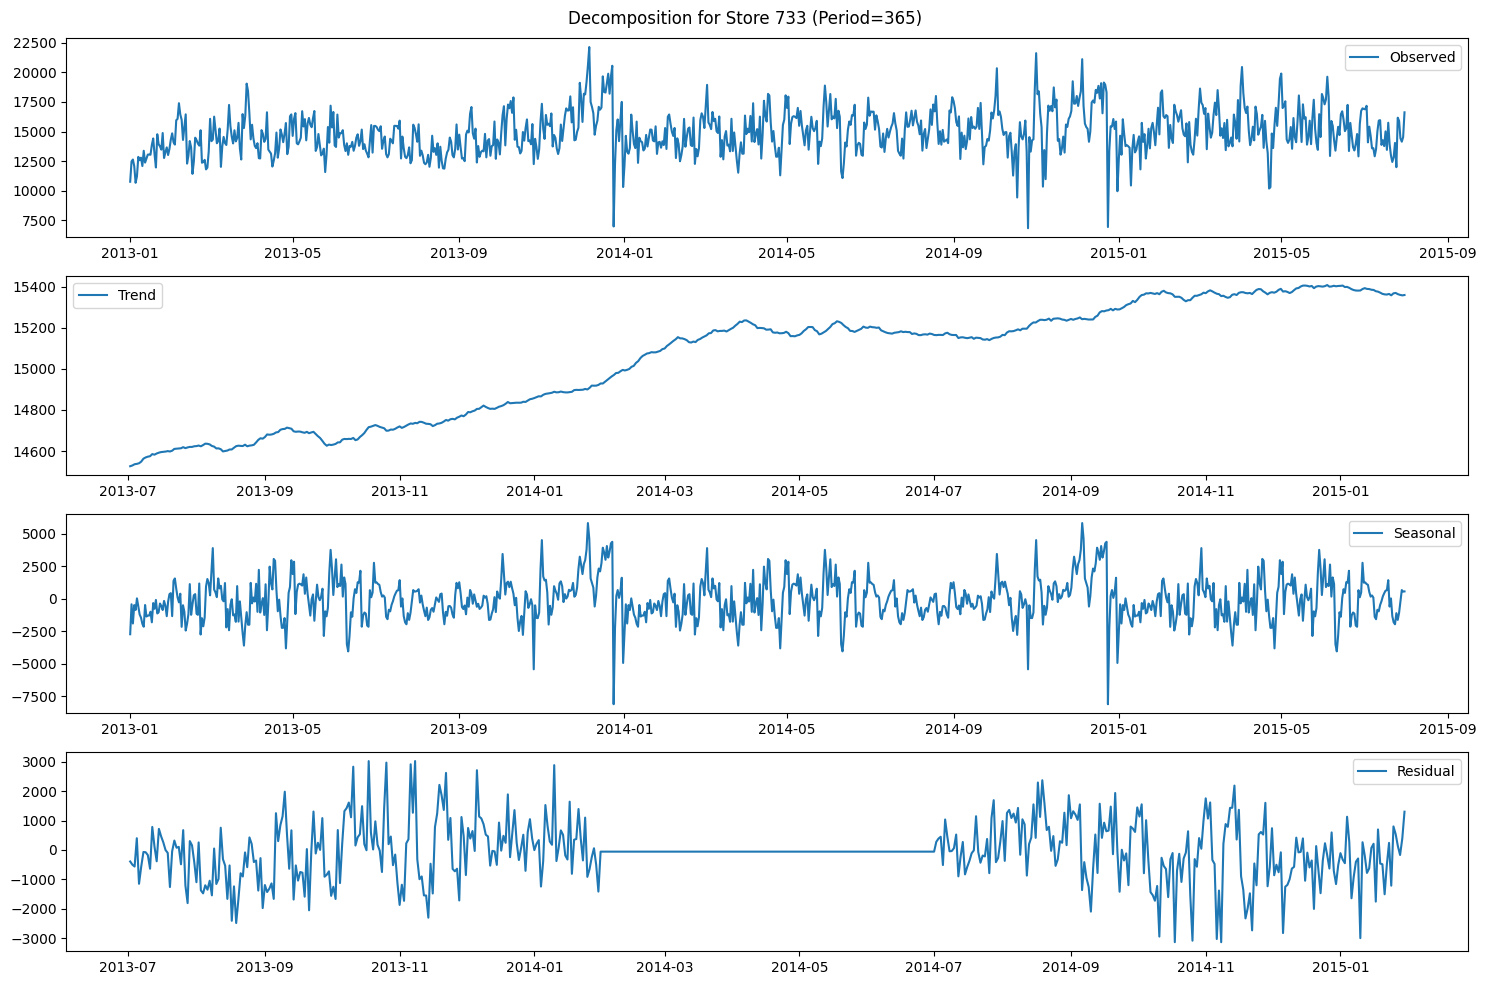

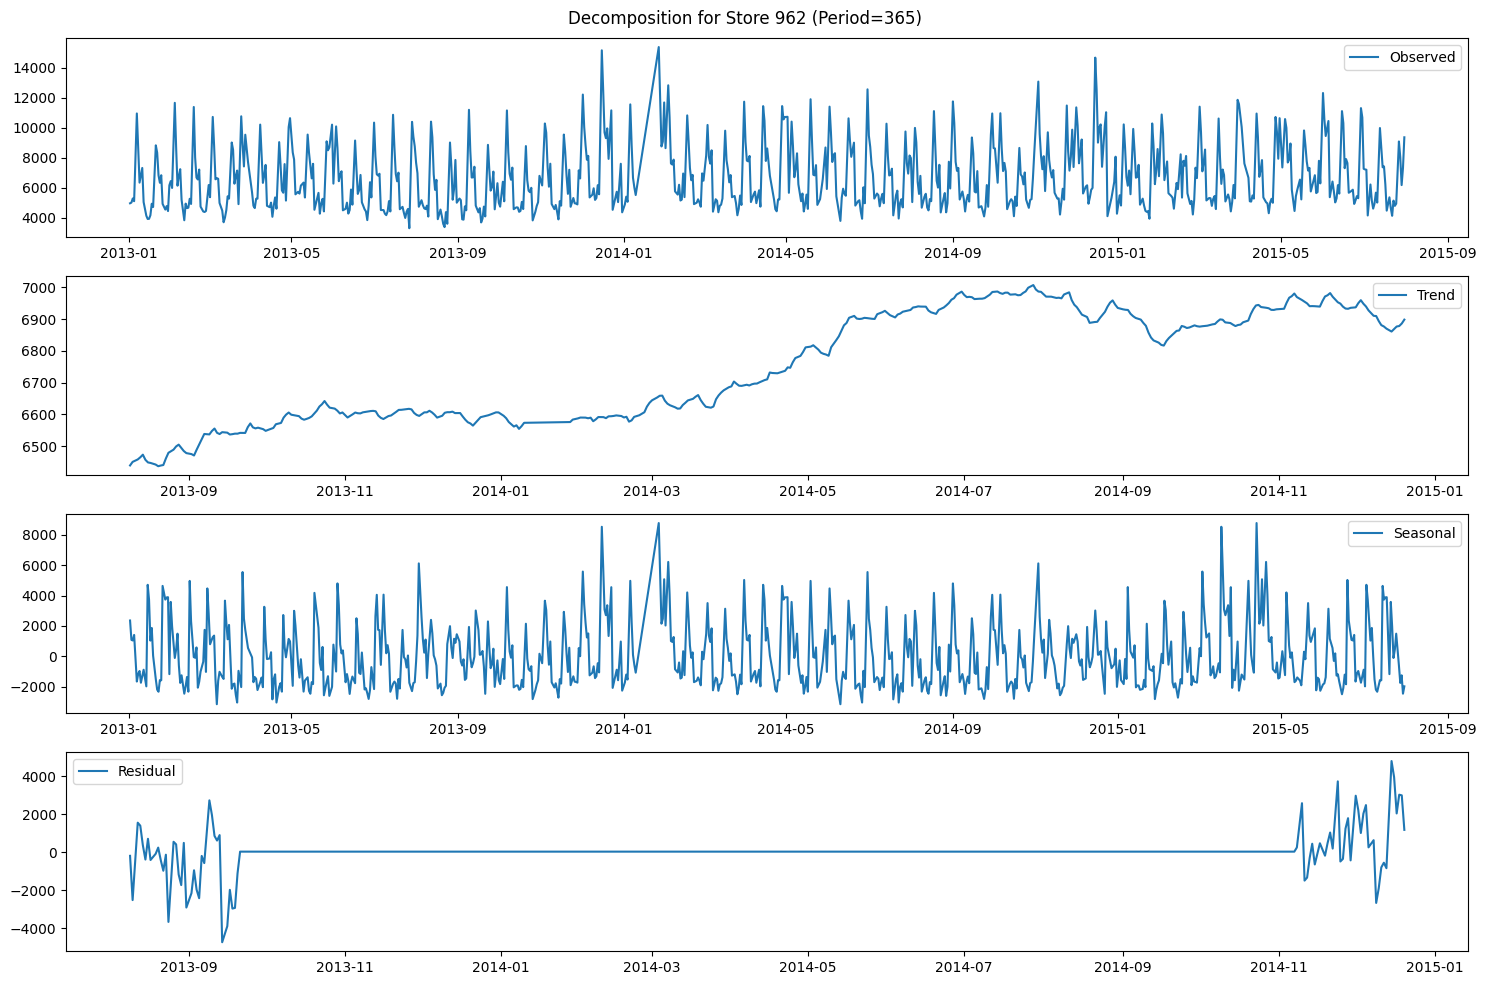

Skipping Store 457 for Period=365 (not enough data points)


In [ ]:
train_date = train.set_index('Date').copy()
train_nonzero = train[train['Sales'] > 0]
stores_by_type = train_nonzero.groupby('StoreType')['Store'].unique()
store_types = ['a', 'b', 'c', 'd']
stores_to_analyze = []
np.random.seed(1234)

# Select one store from each store type for decomposition
for store_type in store_types:
    selected_store = np.random.choice(stores_by_type[store_type])
    stores_to_analyze.append(selected_store)


# weekly,monthly,yearly seasonality
periods_to_try = [7, 30, 365]  

for period in periods_to_try:
    for store_id in stores_to_analyze:
        store_data = train_date[(train_date['Store'] == store_id) & (train_date['Sales'] > 0)].sort_index()

        # Check if there are enough data points
        if store_data.empty:
            print(f"Skipping Store {store_id} for Period={period} (no data points)")
            continue
        if len(store_data) < 2 * period:
            print(f"Skipping Store {store_id} for Period={period} (not enough data points)")
            continue

        decomposition = seasonal_decompose(store_data['Sales'], model='additive', period=period)
        plt.figure(figsize=(15,10))
        plt.suptitle(f'Decomposition for Store {store_id} (Period={period})')
        plt.subplot(411)
        plt.plot(decomposition.observed, label='Observed')
        plt.legend()
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend()
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.legend()
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend()
        plt.tight_layout()
        plt.show()


### **ACF and PACF**
- with diffirent lag

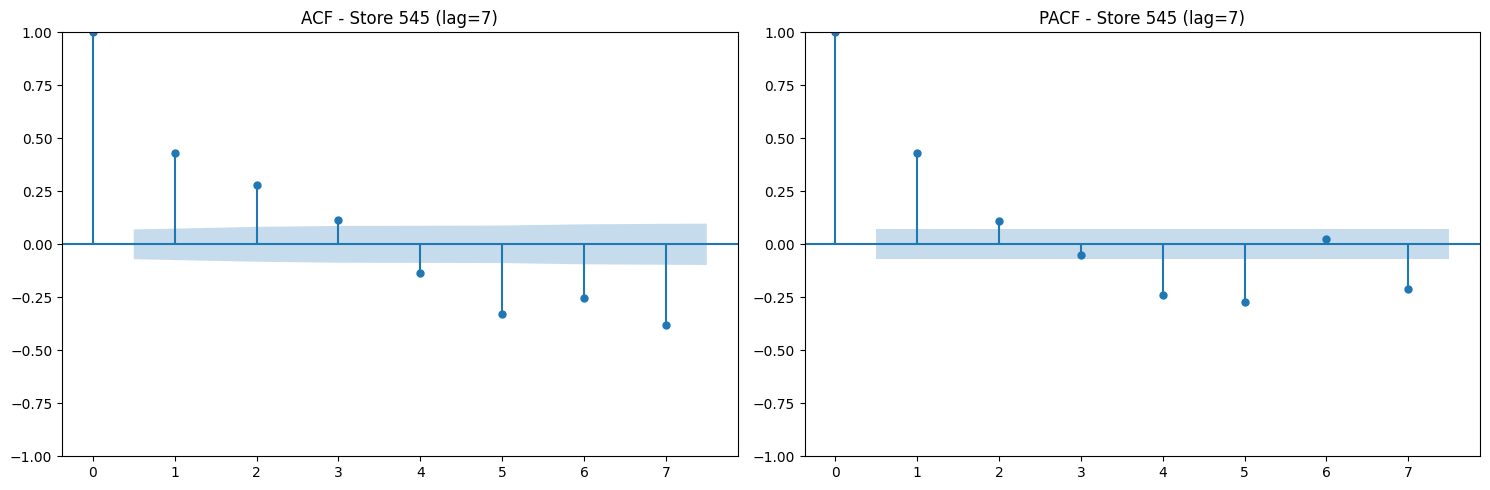

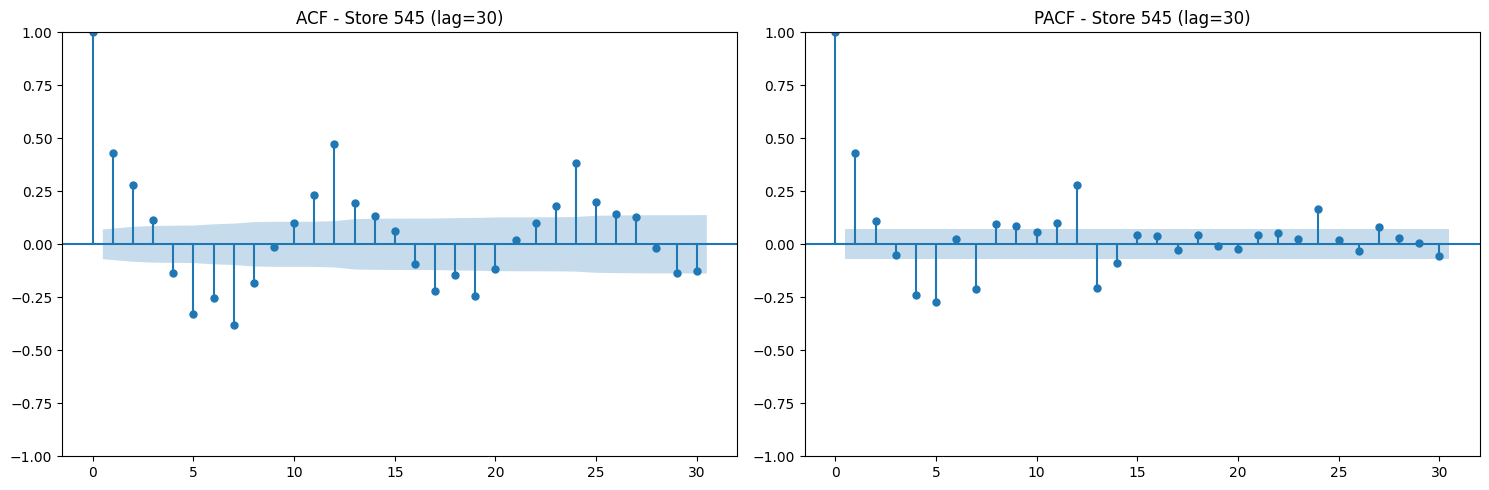

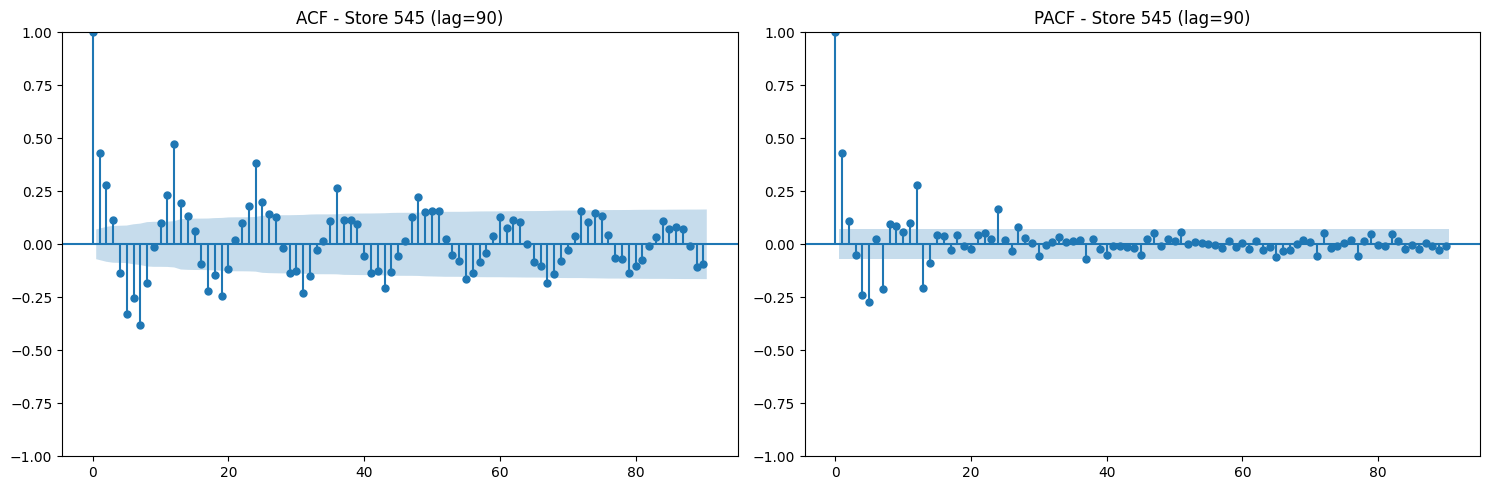

In [ ]:
store_id = stores_to_analyze[0]
store_data = train_date[(train_date['Store'] == store_id) & (train_date['Sales'] > 0)]
store_data = store_data.sort_index()

# weekly, monthly, quarterly lags
lags_to_try = [7,30,90] 

for lag in lags_to_try:
    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plot_acf(store_data['Sales'], lags=lag, ax=plt.gca())
    plt.title(f"ACF - Store {store_id} (lag={lag})")

    plt.subplot(1, 2, 2)
    plot_pacf(store_data['Sales'], lags=lag, ax=plt.gca(), method='ywm')
    plt.title(f"PACF - Store {store_id} (lag={lag})")

    plt.tight_layout()
    plt.show()

### **Rolling mean**
- with diffirent window size

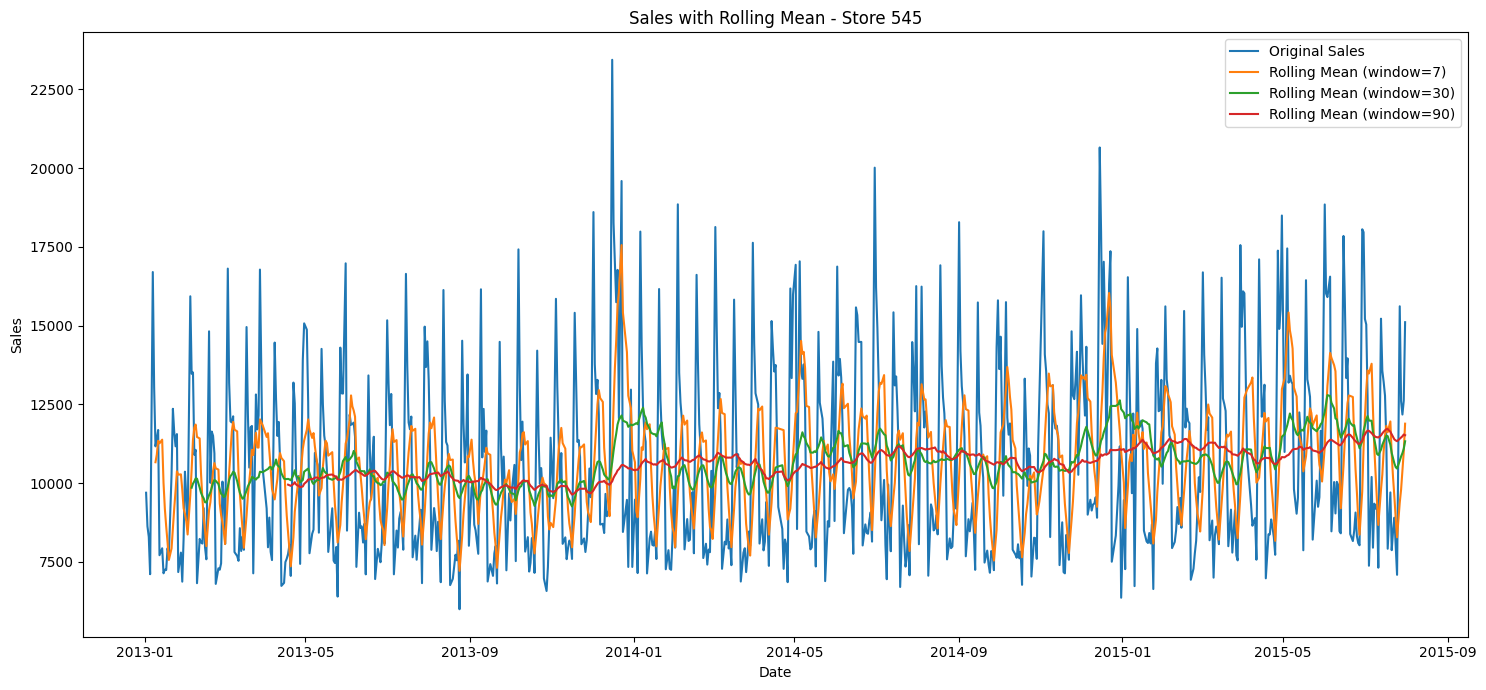

In [99]:
store_id = stores_to_analyze[0]
store_data = train_date[(train_date['Store'] == store_id) & (train_date['Sales'] > 0)].sort_index()

# weekly, monthly, quarterly rolling means
window_sizes = [7, 30, 90]

plt.figure(figsize=(15,7))
plt.plot(store_data['Sales'], label='Original Sales')

for window in window_sizes:
    rolling_mean = store_data['Sales'].rolling(window=window).mean()
    plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')

plt.title(f'Sales with Rolling Mean - Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# `E` Summary Notes

###  1. **Data Preprocessing**
- Filtered out days with zero sales to avoid distortion from closed stores.
- Sorted the time series index to ensure correct temporal ordering.

---

###  2. **Time Series Decomposition**

####  Store 962 (Period = 365, yearly seasonality):
- **Trend**: Gradual upward movement from mid-2013 to mid-2014, then stabilizes.
- **Seasonal**: Strong yearly patterns visible in the seasonal component.
- **Residuals**: Flat (zeroed) during some periods — likely due to insufficient data length for full decomposition.
- **Insight**: Long-term planning might benefit from yearly seasonality modeling.

####  Store 545 (Period = 7, weekly seasonality):
- **Trend**: Fluctuating trend with a noticeable sales spike around late 2013.
- **Seasonal**: Very strong and consistent **weekly seasonality**.
- **Residuals**: No missing segments; shows remaining noise after accounting for trend and seasonality.
- **Insight**: Weekly seasonality plays a major role in this store’s sales behavior.

---

###  3. **Autocorrelation Analysis (ACF & PACF)**

- Used ACF and PACF plots with lag ranges from 30 to 90.
- **ACF** shows clear autocorrelation at lags of 7, 14, etc. → confirms **weekly cycles**.
- **PACF** highlights strong partial correlations at lag 7.
- **Perfect lag** for modeling likely to be **7**, due to repetitive weekly structure.

---

###  4. **Rolling Mean Analysis**

- Applied rolling means with **window sizes** : 7 , 30 , and 90 days.
- **7-day window**: Tracks weekly sales variation, captures cyclic spikes.
- **30-day window**: Smooths short-term volatility, reflects monthly cycles.
- **90-day window**: Reveals long-term sales trend — shows stability with slight upward momentum.
- **Insight**: Clear seasonality and trend components useful for forecasting.

---

# `02` **simple Forecasting models**
1) Naive Forecast — next value = last observed

2) Moving Average — average of last N days

3) Weighted Moving Average — weighted average of last N day

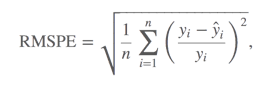

### calculate RMSPE function

In [137]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))

### select store number 545

In [ ]:
store_id = 454
single_store = train_date[train_date['Store'] == store_id].copy()
single_store = single_store[single_store['Open'] == 1].sort_index()
sales = single_store['Sales']
sales = sales[sales > 0]

validation_days = 30
train_data = single_store.iloc[:-validation_days].copy()
valid_data = single_store.iloc[-validation_days:].copy()
y_true = valid_data['Sales'].values

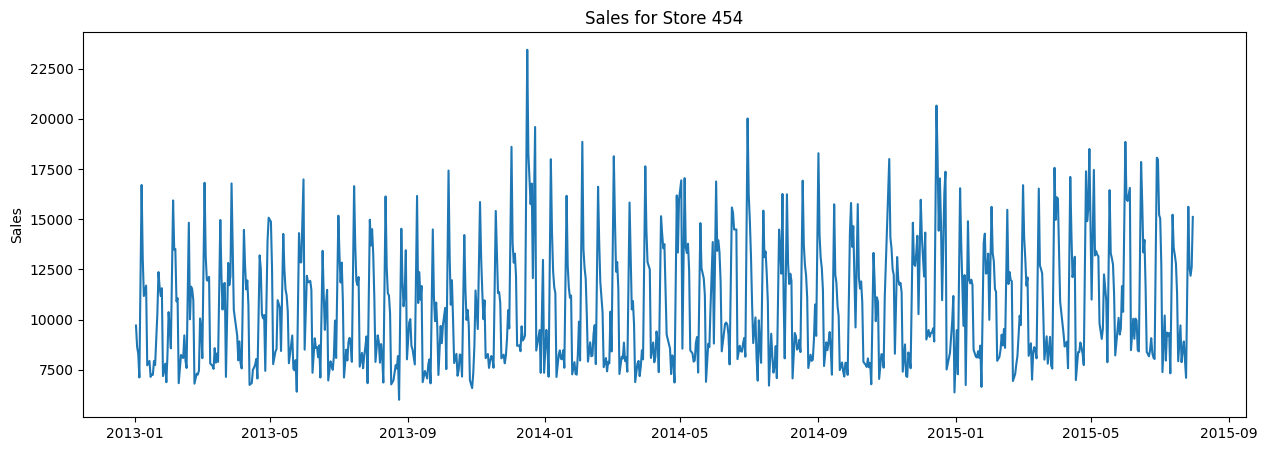

In [154]:
plt.figure(figsize=(15,5))
plt.plot(sales, label='Original Sales')
plt.title(f'Sales for Store {store_id}')
plt.ylabel('Sales')
plt.show()

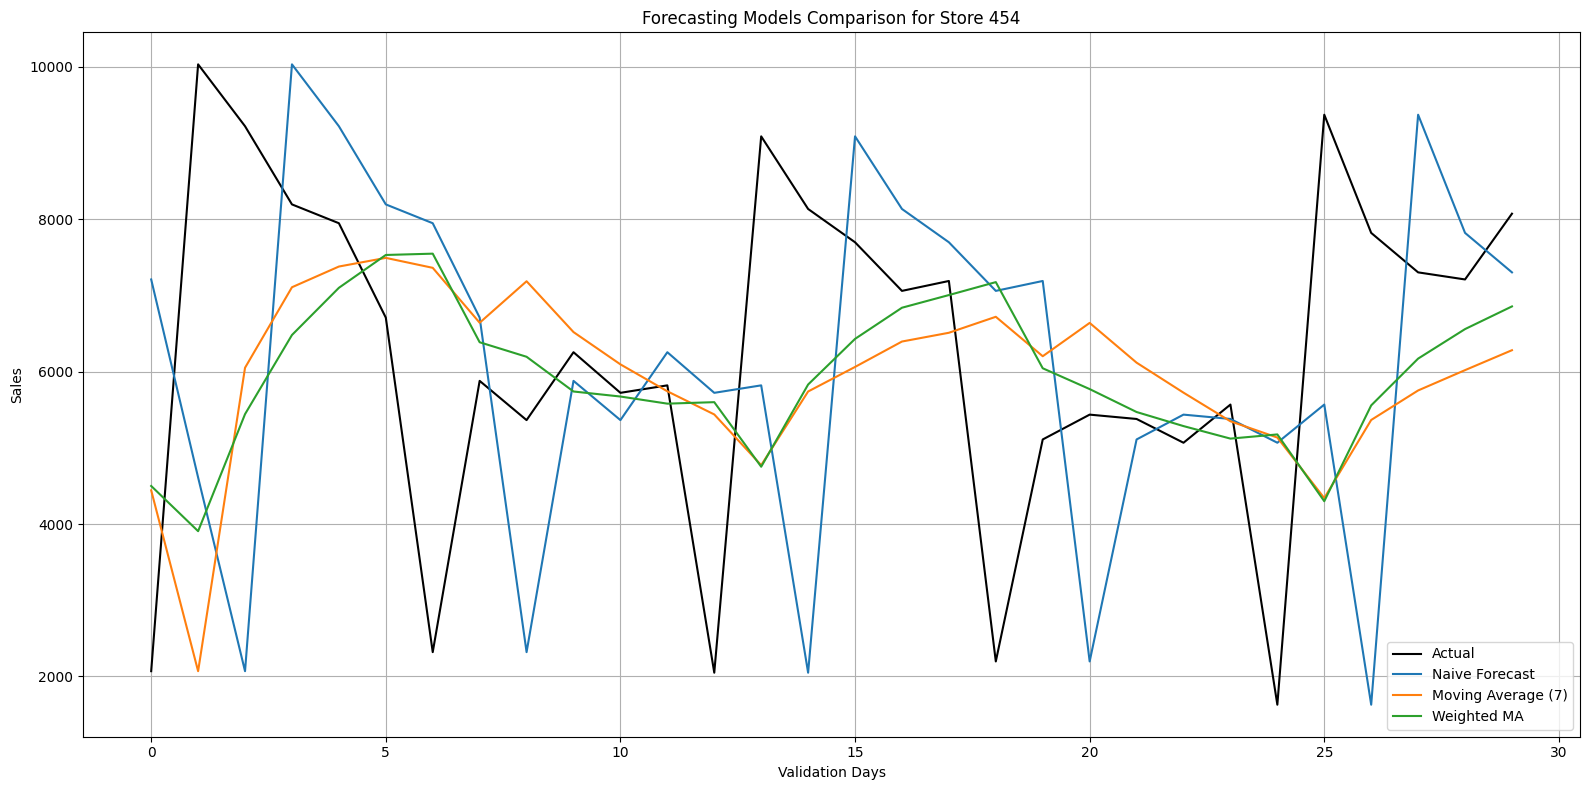

In [164]:
# 1. Naive Forecast
y_pred_naive = np.roll(np.append(train_data['Sales'].iloc[-1], valid_data['Sales'][:-1]), 1)

# 2. Moving Averages
ma_preds = {}

window = 7
train_data[f'MA_{window}'] = train_data['Sales'].rolling(window=window, min_periods=1).mean()
last_ma = train_data[f'MA_{window}'].iloc[-1]
y_pred_ma = np.array([last_ma]+[valid_data['Sales'].iloc[max(0, i - window):i].mean() for i in range(1, len(valid_data))])
ma_preds[window] = y_pred_ma

# 3. Weighted Moving Average
window = 7
weights = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
weights /= weights.sum()
y_pred_wma = []
last_values = train_data['Sales'].iloc[-window:].values
for i in range(len(valid_data)):
    forecast = np.sum(last_values * weights)
    y_pred_wma.append(forecast)
    last_values = np.roll(last_values, -1)
    if i < len(valid_data) - 1:
        last_values[-1] = valid_data['Sales'].iloc[i]
y_pred_wma = np.array(y_pred_wma)

plt.figure(figsize=(16, 8))
plt.plot(range(len(y_true)), y_true, label='Actual', color='black',)
plt.plot(range(len(y_pred_naive)), y_pred_naive, label='Naive Forecast')
plt.plot(range(len(ma_preds[7])), ma_preds[7], label='Moving Average (7)')
plt.plot(range(len(y_pred_wma)), y_pred_wma, label='Weighted MA')
plt.title(f'Forecasting Models Comparison for Store {store_id}')
plt.xlabel('Validation Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# `03` **ETS models (Error, Trend, Seasonality)**
- Let's explore different Exponential Smoothing methods :

1)    Simple Exponential Smoothing (SES) handles level only
2)    Holt’s Linear Trend Model (Double Exponential Smoothing) handles level and trend
3)    Holt-Winters’ Seasonal Method (Triple Exponential Smoothing) handles level, trend, and seasonality

c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

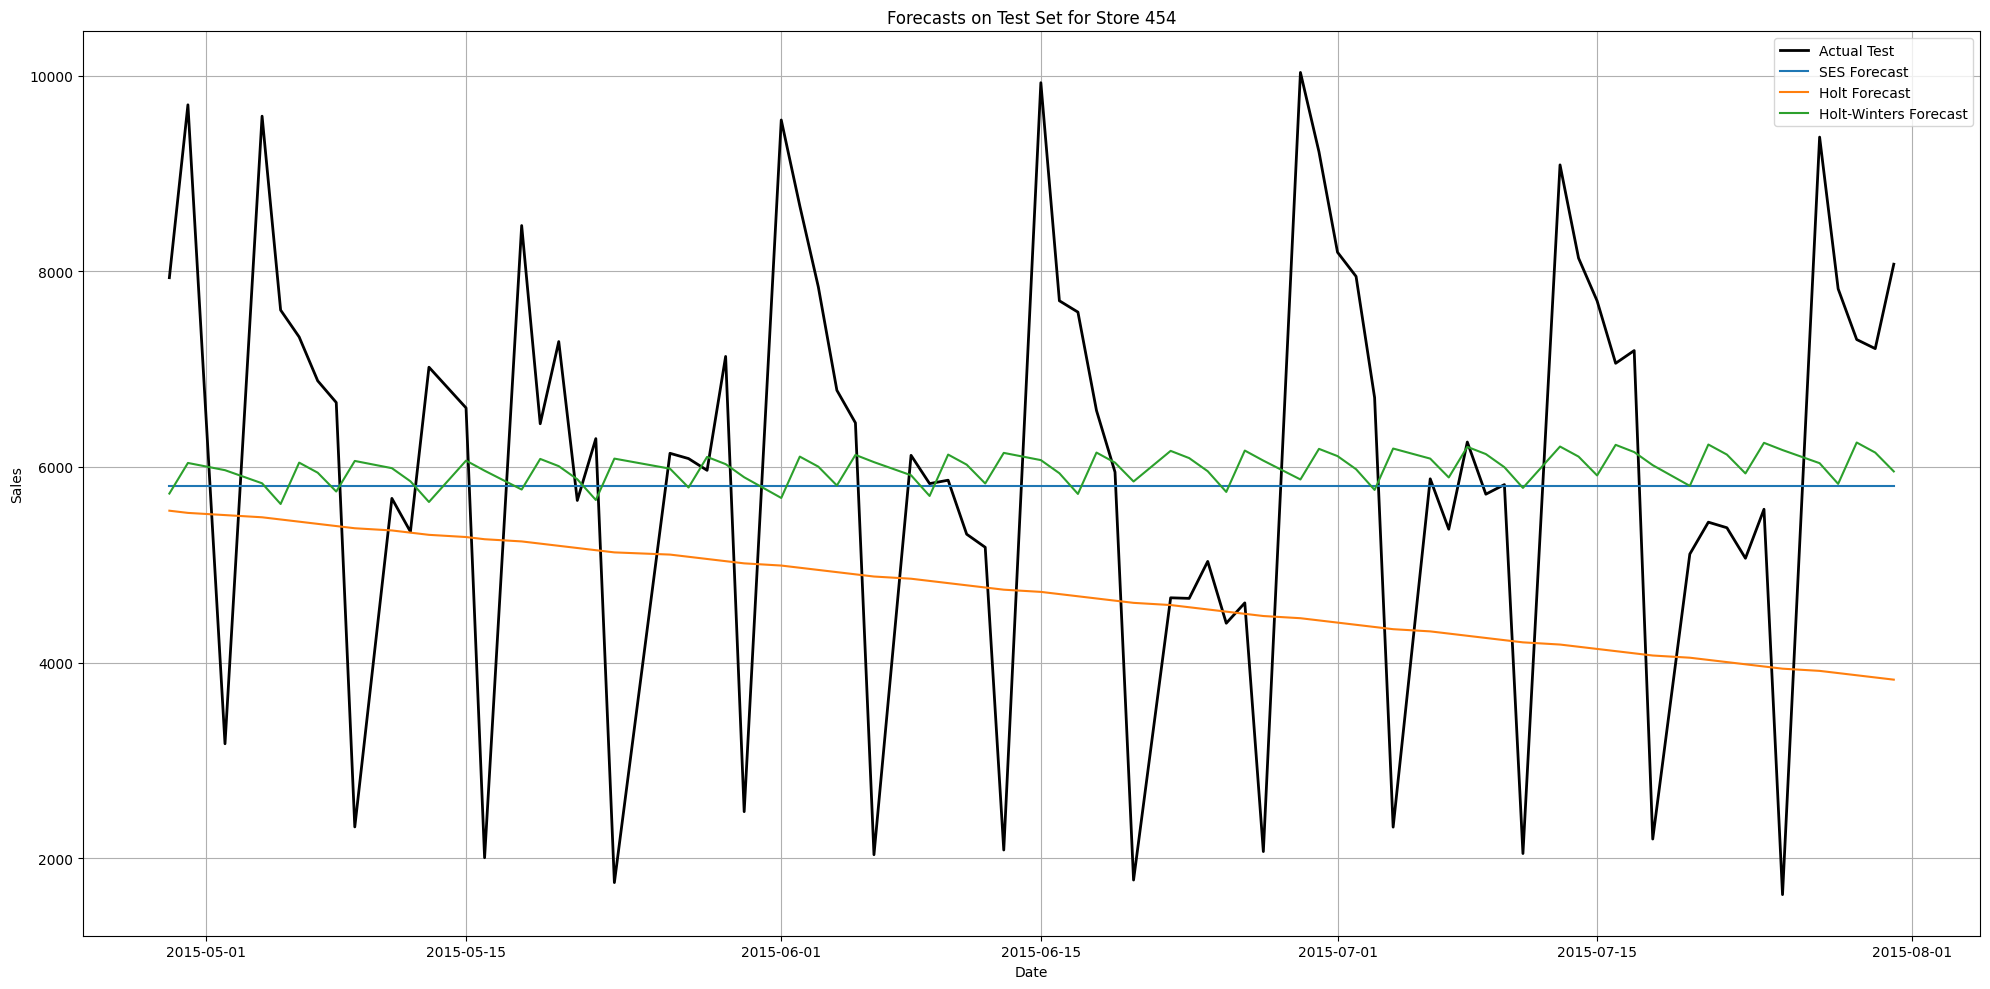

In [ ]:


train_size = int(len(sales) * 0.9)
train, test = sales[:train_size], sales[train_size:]
results = {}

# Simple Exponential Smoothing (SES) 
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))
results["SES"] = rmspe(test, ses_forecast)

# Holt’s Linear Trend Method
holt_model = Holt(train).fit()
holt_forecast = holt_model.forecast(len(test))
results["Holt"] = rmspe(test, holt_forecast)

# Holt-Winters’ Seasonal Method 
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7).fit()
hw_forecast = hw_model.forecast(len(test))
results["Holt-Winters"] = rmspe(test, hw_forecast)

plt.figure(figsize=(20,10))
plt.plot(test, label='Actual Test', color='black', linewidth=2)
plt.plot(test.index, ses_forecast, label='SES Forecast')
plt.plot(test.index, holt_forecast, label='Holt Forecast')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast')
plt.title(f"Forecasts on Test Set for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
print("RMSPE Scores:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")

RMSPE Scores:
SES: 0.7737
Holt: 0.6066
Holt-Winters: 0.8147


c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Omar Elgema3y\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

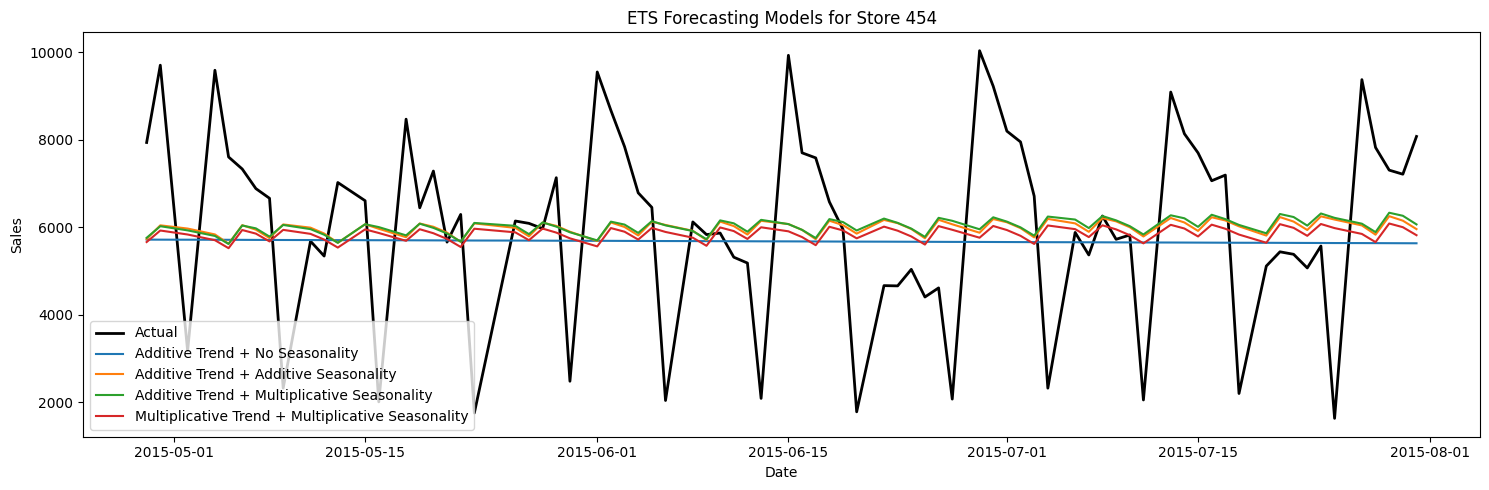

In [165]:
ets_configs = {
    "Additive Trend + No Seasonality": dict(trend="add", seasonal=None),
    "Additive Trend + Additive Seasonality": dict(trend="add", seasonal="add", seasonal_periods=7),
    "Additive Trend + Multiplicative Seasonality": dict(trend="add", seasonal="mul", seasonal_periods=7),
    "Multiplicative Trend + Multiplicative Seasonality": dict(trend="mul", seasonal="mul", seasonal_periods=7),
}

results = {}
predictions = {}

for label, cfg in ets_configs.items():
    model = ExponentialSmoothing(train, **cfg).fit()
    forecast = model.forecast(len(test))
    score = rmspe(test, forecast)
    results[label] = score
    predictions[label] = forecast


plt.figure(figsize=(15,5))
plt.plot(test, label="Actual", color="black", linewidth=2)
for label, forecast in predictions.items():
    plt.plot(test.index, forecast, label=label)
plt.title(f"ETS Forecasting Models for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [166]:
print(" ETS Model RMSPE Scores:")
for label, score in results.items():
    print(f"{label}: {score}")

 ETS Model RMSPE Scores:
Additive Trend + No Seasonality: 0.7494766573161858
Additive Trend + Additive Seasonality: 0.8147021996092202
Additive Trend + Multiplicative Seasonality: 0.8205074258855943
Multiplicative Trend + Multiplicative Seasonality: 0.7882981374101743


# `04` **Arima model**

ADF Statistic: -6.278712606086133
p-value: 3.8433724638774495e-08
Series is stationary


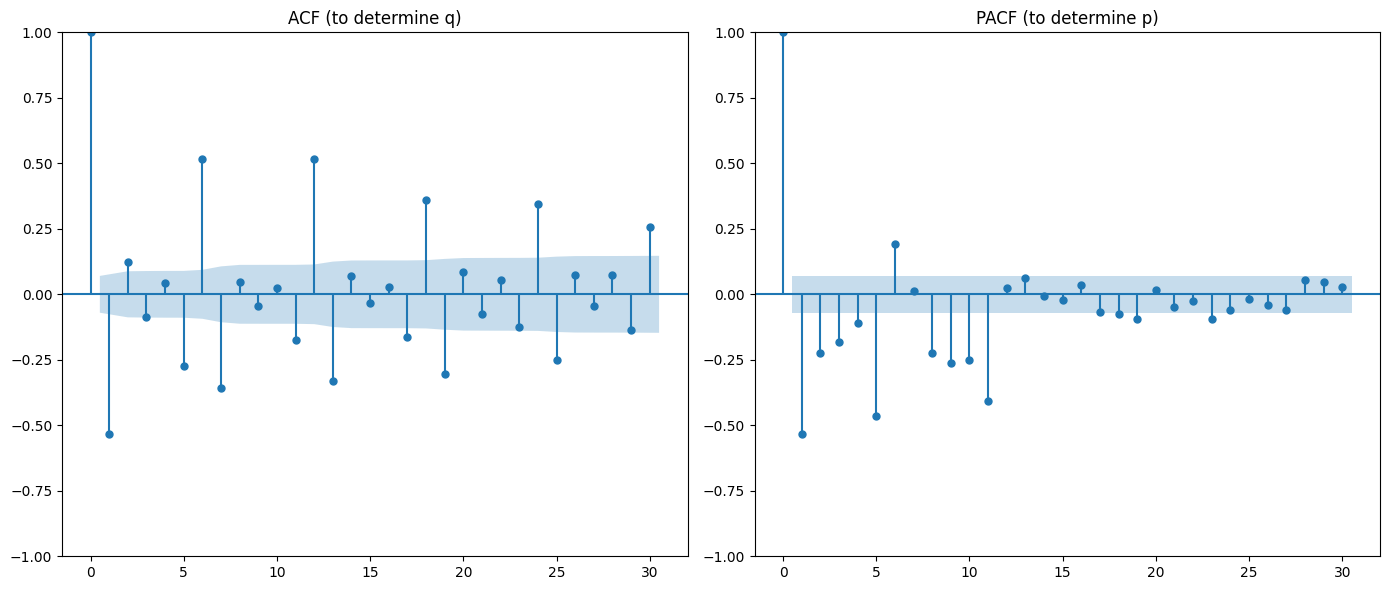

In [ ]:
adf_result = adfuller(sales)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is NOT stationary (p > 0.05)")
sales_diff = sales.diff().dropna()


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(sales_diff, ax=plt.gca(), lags=30)
plt.title("ACF (to determine q)")
plt.subplot(1, 2, 2)
plot_pacf(sales_diff, ax=plt.gca(), lags=30, method='ywm')
plt.title("PACF (to determine p)")
plt.tight_layout()
plt.show()

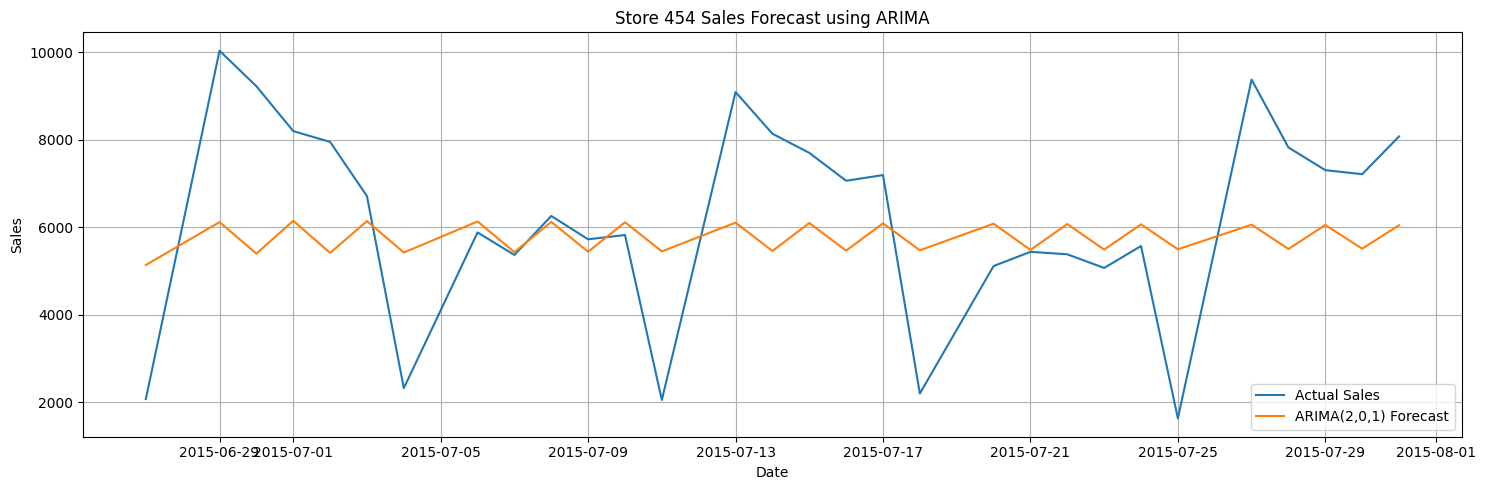

In [179]:
validation_days = 30
train_series = single_store.iloc[:-validation_days]['Sales']
valid_series = single_store.iloc[-validation_days:]['Sales']
valid_dates = single_store.iloc[-validation_days:].index

p, d, q = 2,0,1 
arima_model = ARIMA(train_series, order=(p, d, q))
arima_result = arima_model.fit()

forecast = arima_result.forecast(steps=validation_days)
y_pred_arima = forecast.values
y_true = valid_series.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred_arima))
mae = mean_absolute_error(y_true, y_pred_arima)
rmspe_value = rmspe(y_true, y_pred_arima)


plt.figure(figsize=(15,5))
plt.plot(valid_dates, y_true, label='Actual Sales')
plt.plot(valid_dates, y_pred_arima, label=f'ARIMA({p},{d},{q}) Forecast')
plt.title(f'Store {store_id} Sales Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [182]:
print(f"ARIMA({p},{d},{q}) \n RMSE: {rmse:.2f},\n MAE: {mae:.2f},\n RMSPE: {rmspe_value:.4f}")


ARIMA(2,0,1) 
 RMSE: 2210.98,
 MAE: 1794.61,
 RMSPE: 0.7268


# `05` **Prophet model**

01:17:57 - cmdstanpy - INFO - Chain [1] start processing
01:17:59 - cmdstanpy - INFO - Chain [1] done processing


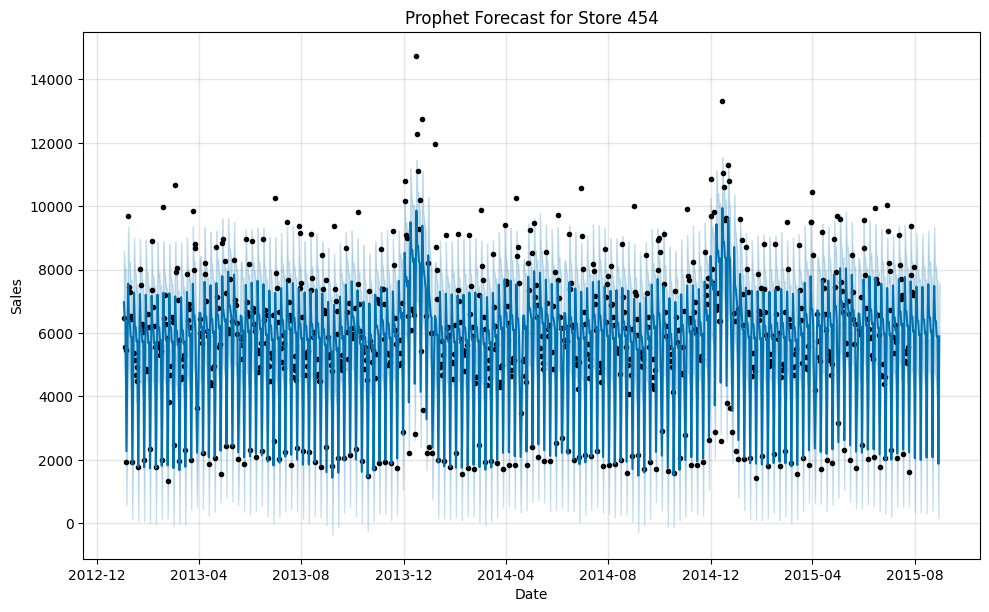

In [ ]:
df_prophet = single_store.reset_index()[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=validation_days)
forecast = model.predict(future)

model.plot(forecast)
plt.title(f"Prophet Forecast for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


01:50:08 - cmdstanpy - INFO - Chain [1] start processing
01:50:08 - cmdstanpy - INFO - Chain [1] done processing


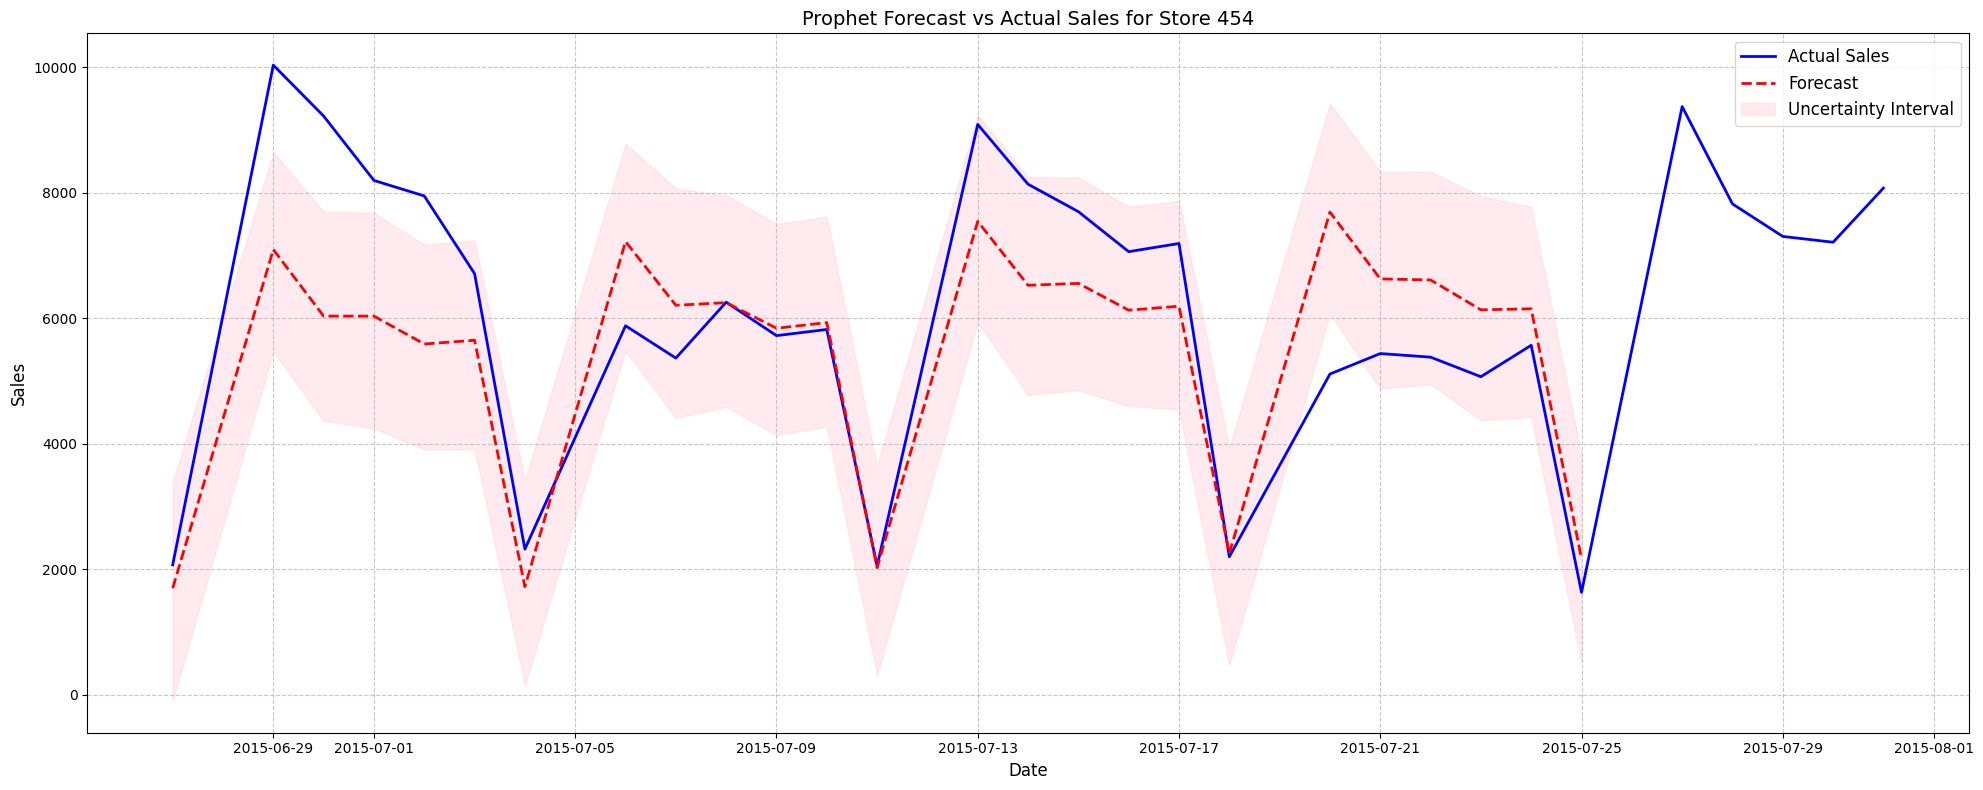

In [254]:
train_df = df_prophet.iloc[:-validation_days]
valid_df = df_prophet.iloc[-validation_days:]


model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,   
    daily_seasonality=False
)
model.fit(train_df)

future = model.make_future_dataframe(periods=validation_days, include_history=False)
forecast = model.predict(future)
forecast_valid = forecast[forecast['ds'].isin(valid_df['ds'])]

plt.figure(figsize=(20,8))
plt.plot(valid_df['ds'], valid_df['y'], 'b-', label='Actual Sales', linewidth=2)
plt.plot(forecast_valid['ds'], forecast_valid['yhat'], 'r--', label='Forecast', linewidth=2)
plt.fill_between(
    forecast_valid['ds'],
    forecast_valid['yhat_lower'],
    forecast_valid['yhat_upper'],
    color='pink',
    alpha=0.3,
    label='Uncertainty Interval'
)
plt.title(f"Prophet Forecast vs Actual Sales for Store {store_id}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

merged = valid_df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='inner')
y_true = merged['y'].values
y_pred = merged['yhat'].values

In [255]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
rmspe_value = rmspe(y_true, y_pred)

print(f"Prophet Model \n RMSE: {rmse:.2f},\n MAE: {mae:.2f},\n RMSPE: {rmspe_value:.4f}")

Prophet Model 
 RMSE: 1452.22,
 MAE: 1143.87,
 RMSPE: 0.2201


# `06` **machine learning model**

- **Random forest model**

In [238]:
single_store['day_of_week'] = single_store.index.dayofweek
single_store['month'] = single_store.index.month
single_store['day_of_month'] = single_store.index.day
single_store['year'] = single_store.index.year
single_store['Customers'] = single_store['Customers'].fillna(0)
single_store['Promo'] = single_store['Promo'].astype(int)
single_store['StateHoliday'] = single_store['StateHoliday'].astype(int)
single_store['SchoolHoliday'] = single_store['SchoolHoliday'].astype(int)

validation_days = 30
train_df = single_store[:-validation_days].copy()
valid_df = single_store[-validation_days:].copy()

features = ['day_of_week', 'month', 'day_of_month', 'year', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType','Assortment']

X_train = train_df[features].copy()
X_valid = valid_df[features].copy()

for col in ['StoreType', 'Assortment']:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_valid[col] = X_valid[col].astype('category').cat.codes

y_train = train_df['Sales']
y_valid = valid_df['Sales']

In [239]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=1234,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_jobs=-1,
                      random_state=1234)

In [252]:
y_pred = rf.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmspe_value = rmspe(y_valid, y_pred)
print(f"Random Forest Model Evaluation for Store {store_id}:")
print(f" MSE: {mse:.2f}")
print(f" MAE: {mae:.2f}")
print(f" RMSPE: {rmspe_value:.4f}")

Random Forest Model Evaluation for Store 454:
 MSE: 273294.13
 MAE: 438.57
 RMSPE: 0.0937


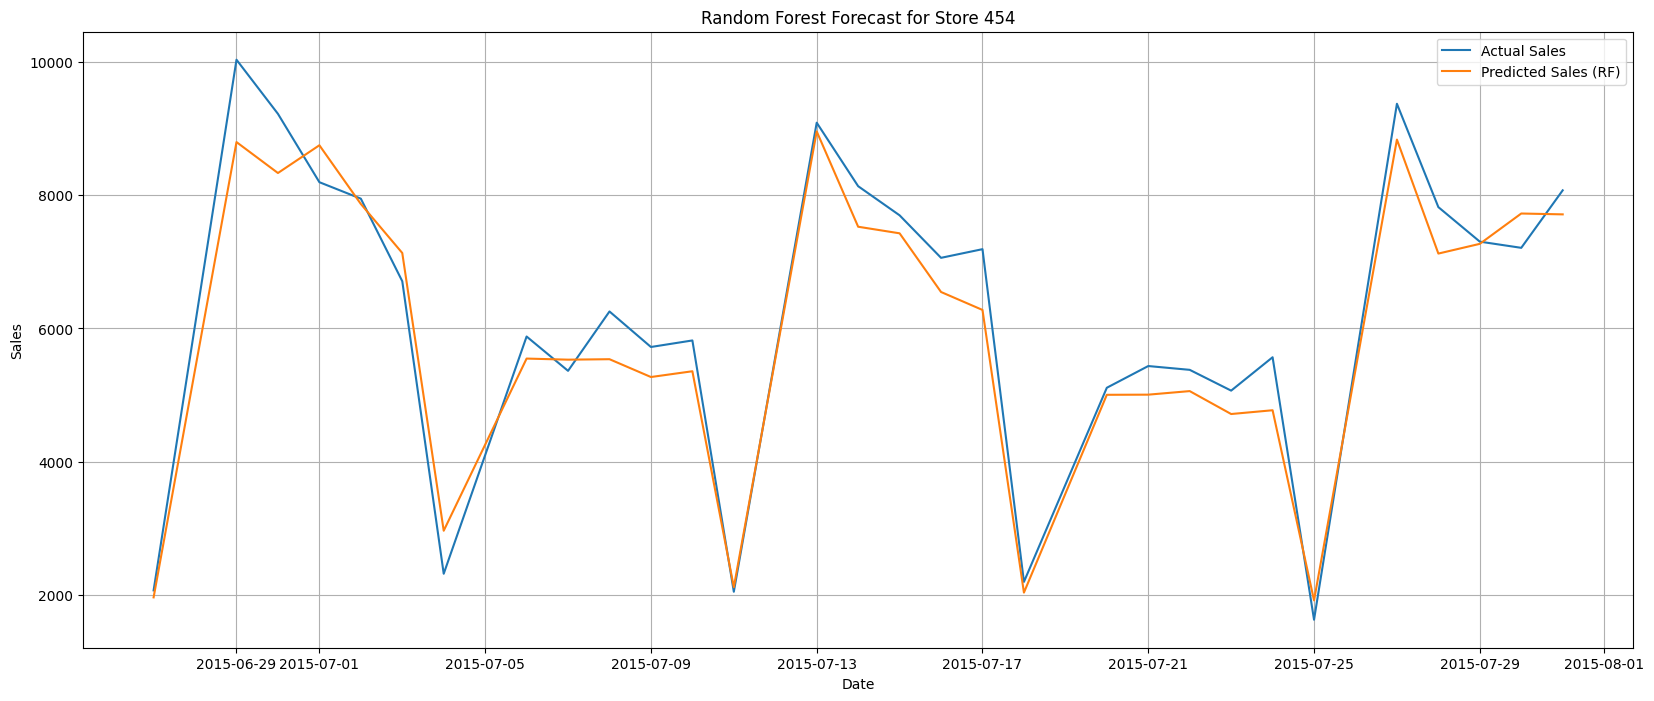

In [241]:
plt.figure(figsize=(20,8))
plt.plot(valid_df.index, y_valid, label='Actual Sales')
plt.plot(valid_df.index, y_pred, label='Predicted Sales (RF)')
plt.title(f"Random Forest Forecast for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

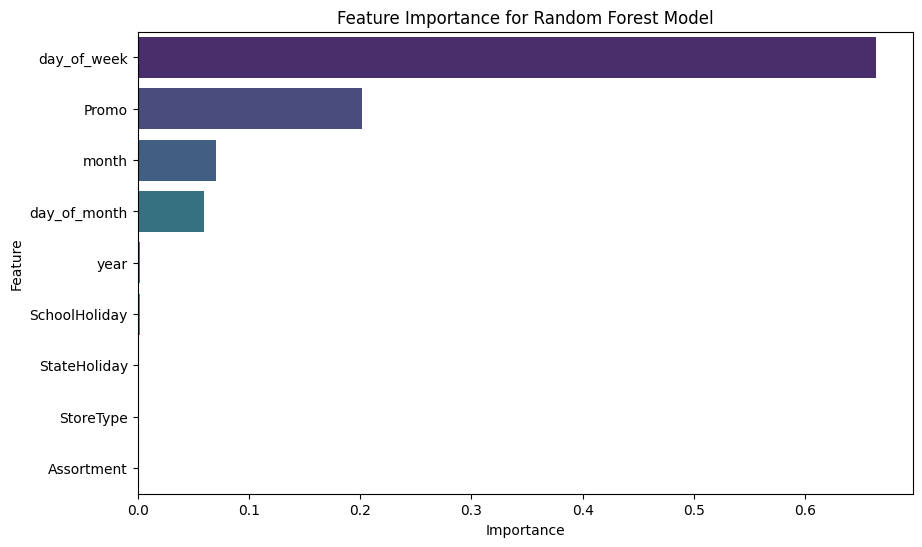

In [242]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Random Forest Model')
plt.show()

- **XGB boost model**

In [ ]:
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=1234
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [251]:
y_pred1 = xgb.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred1)
mae = mean_absolute_error(y_valid, y_pred1)
rmspe_value = rmspe(y_valid, y_pred1)
print(f"XGBoost  Evaluation for Store {store_id}:")
print(f" MSE: {mse:.2f}")
print(f" MAE: {mae:.2f}")
print(f" RMSPE: {rmspe_value:.4f}")

XGBoost  Evaluation for Store 454:
 MSE: 347547.38
 MAE: 465.08
 RMSPE: 0.1316


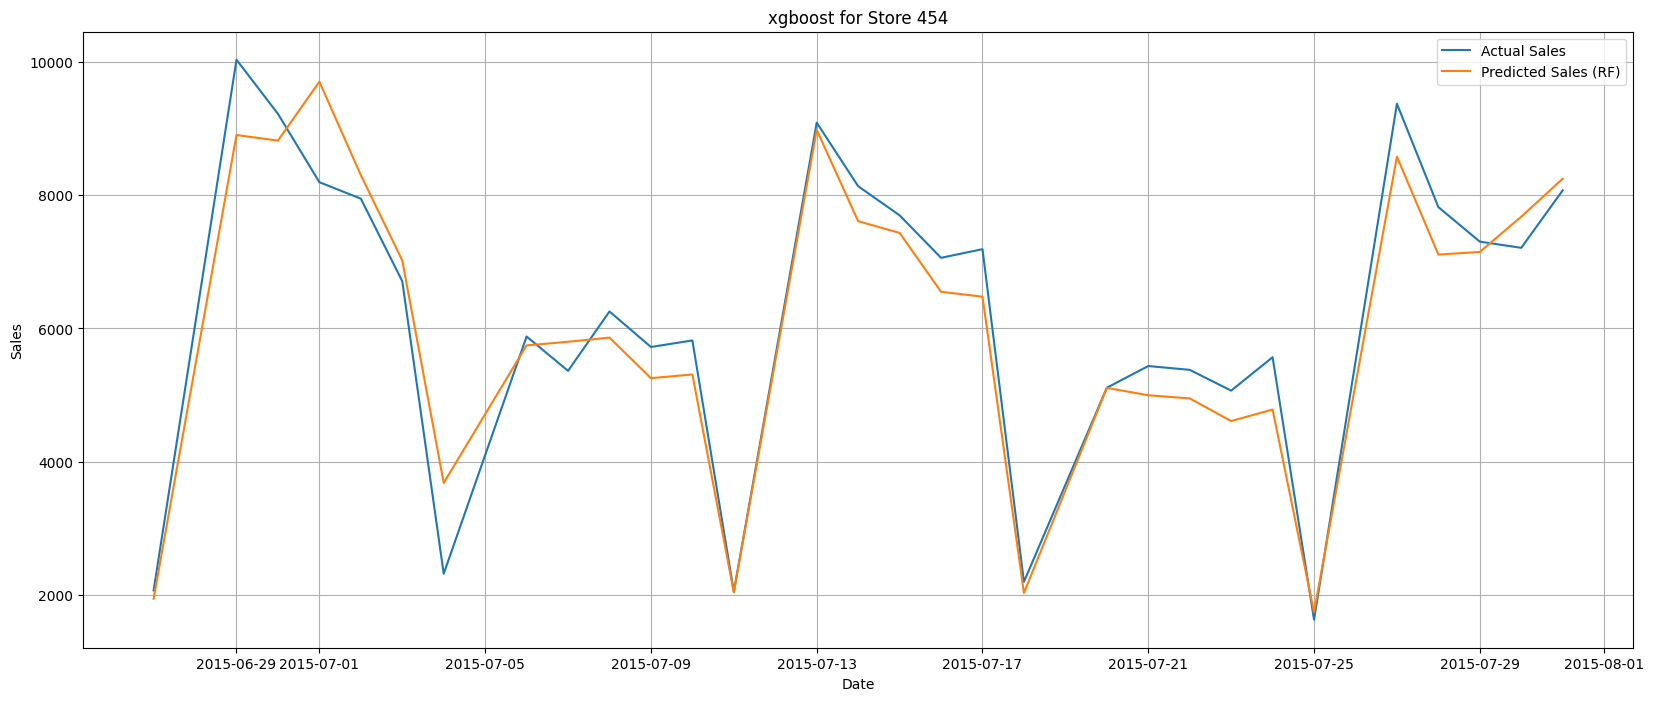

In [249]:
plt.figure(figsize=(20,8))
plt.plot(valid_df.index, y_valid, label='Actual Sales')
plt.plot(valid_df.index, y_pred1, label='Predicted Sales (RF)')
plt.title(f"xgboost for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

- **cat boost model**

In [260]:
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=1234,
    verbose=100
)

catboost_model.fit(X_train, y_train)

0:	learn: 2088.9545514	total: 157ms	remaining: 2m 36s
100:	learn: 471.2900082	total: 311ms	remaining: 2.77s
200:	learn: 345.1702275	total: 570ms	remaining: 2.27s
300:	learn: 276.5397184	total: 783ms	remaining: 1.82s
400:	learn: 232.5986343	total: 941ms	remaining: 1.41s
500:	learn: 201.3798538	total: 1.11s	remaining: 1.11s
600:	learn: 176.2317729	total: 1.23s	remaining: 814ms
700:	learn: 158.4612971	total: 1.33s	remaining: 569ms
800:	learn: 142.2333399	total: 1.47s	remaining: 365ms
900:	learn: 128.3072659	total: 1.64s	remaining: 180ms
999:	learn: 117.1183699	total: 1.81s	remaining: 0us


In [261]:
y_pred2 = catboost_model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred2)
mae = mean_absolute_error(y_valid, y_pred2)
rmspe_value = rmspe(y_valid, y_pred2)
print(f"XGBoost  Evaluation for Store {store_id}:")
print(f" MSE: {mse:.2f}")
print(f" MAE: {mae:.2f}")
print(f" RMSPE: {rmspe_value:.4f}")

XGBoost  Evaluation for Store 454:
 MSE: 340464.41
 MAE: 482.43
 RMSPE: 0.1184


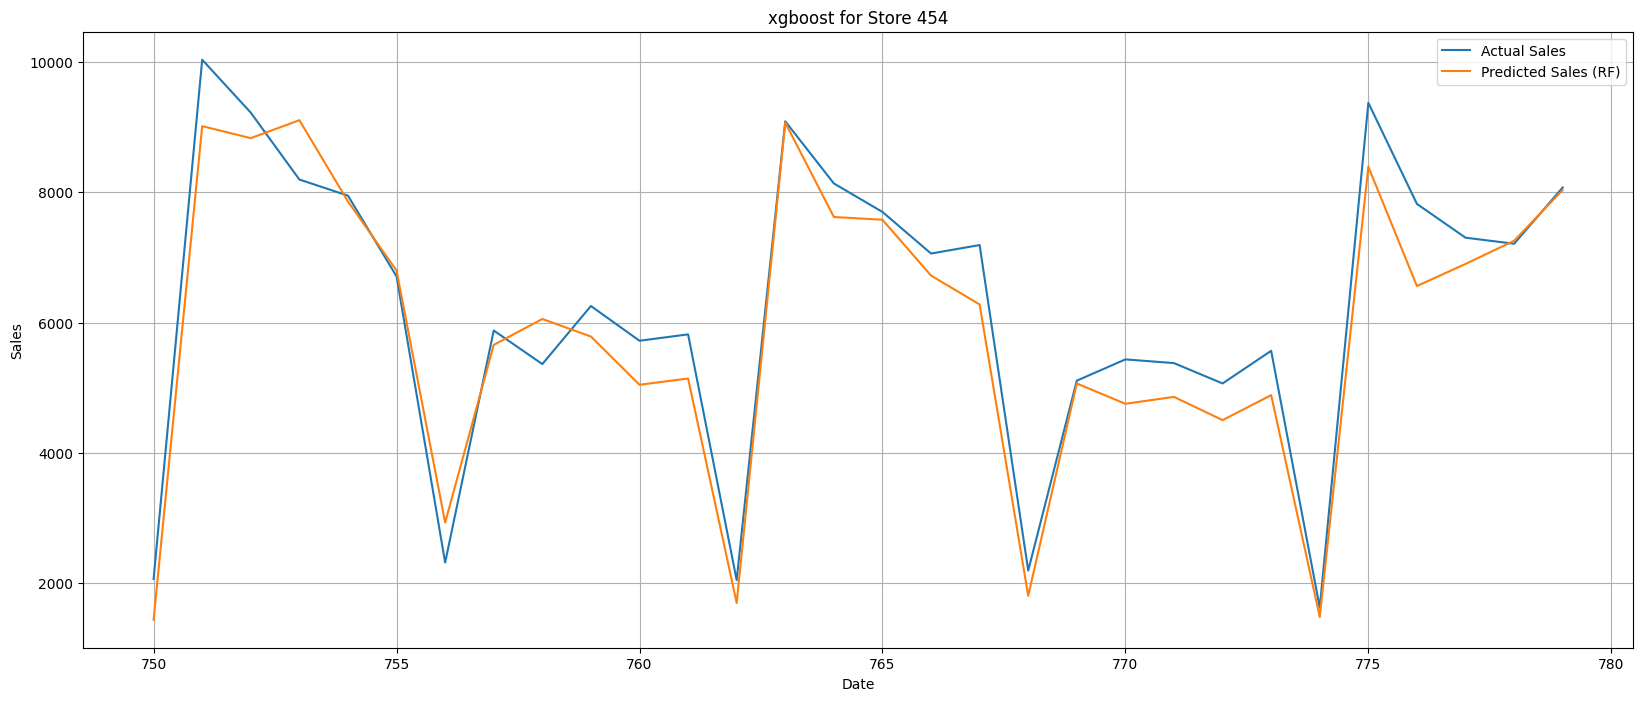

In [262]:
plt.figure(figsize=(20,8))
plt.plot(valid_df.index, y_valid, label='Actual Sales')
plt.plot(valid_df.index, y_pred2, label='Predicted Sales (RF)')
plt.title(f"xgboost for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()